<a href="https://colab.research.google.com/github/Yassinfahmy/updated-project/blob/main/Modeling%20target%20presentation%20to%20the%20motor%20cortex%20using%20RNNs%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#clear all variables from previous session
%reset -f 

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
import os, sys
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

root_dir = "/content/drive/My Drive/"
project_folder= "Colab Notebooks/Rnn modeling/med noise dataset/"

def create_and_set_working_directory(project_folder):
  # check if your project folder exists. if not, it will be created.
  if os.path.isdir(root_dir + project_folder) == False:
     os.mkdir(root_dir + project_folder)
     print(root_dir + project_folder + ' did not exist but was created.')

  # change the OS to use your project folder as the working directory
  os.chdir(root_dir + project_folder)

  # create a test file to make sure it shows up in the right place
  !touch 'new_file_in_working_directory.txt'
  print('\nYour working directory was changed to ' + root_dir + project_folder + \
        "\n\nAn empty text file was created there. You can also run !pwd to confirm the current working directory." )

create_and_set_working_directory(project_folder)


Your working directory was changed to /content/drive/My Drive/Colab Notebooks/Rnn modeling/med noise dataset/

An empty text file was created there. You can also run !pwd to confirm the current working directory.


In [5]:
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt,correlate2d
# from data import get_data, format_data
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
import pandas as pd
from tensorflow.keras.constraints import MaxNorm 
from keras import backend as K  
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter1d
import pickle
import seaborn as sns
from scipy.optimize import curve_fit
from copy import copy
try:
  from psychrnn.backend.models.basic import Basic
  from psychrnn.tasks.task import Task
  from psychrnn.backend.initializations import WeightInitializer
except:
 print('Run next 2 cells to install and import psychrnn')

Run next 2 cells to install and import psychrnn


In [16]:
pip install psychrnn

In [17]:

from psychrnn.backend.models.basic import Basic
from psychrnn.tasks.task import Task
from psychrnn.backend.initializations import WeightInitializer

In [66]:
################################################################################ Helper functions to preprocess data
#Function to delete certain trials from all variables
def delete_trial(array, trial_number):
    array = np.delete(array, trial_number, 0)
    return array

# function to sort out which trials contain missing information and exclude them from the data
def remove_nan_trials(x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time,movment_onset,test_array):
    trials_to_delete = np.where(np.isnan(test_array))#==True)
    trials_to_delete=np.unique(trials_to_delete[0])

    x_trajectory = delete_trial(x_trajectory, trials_to_delete)
    y_trajectory = delete_trial(y_trajectory, trials_to_delete)
    go_cue = delete_trial(go_cue, trials_to_delete)
    x_target = delete_trial(x_target, trials_to_delete)
    y_target = delete_trial(y_target, trials_to_delete)
    flash_1 = delete_trial(flash_1, trials_to_delete)
    offset = delete_trial(offset, trials_to_delete)
    acquire_time = delete_trial(acquire_time, trials_to_delete)
    movment_onset = delete_trial(movment_onset, trials_to_delete)
    
    return x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time,movment_onset

# function to read CSV files containg raw data of the target location, trajectories, timing of the go signal, timing of movment onset, timing of trial start
def get_data():
    x_trajectory = np.genfromtxt('xTraj.csv', delimiter=',')
    y_trajectory = np.genfromtxt('yTraj.csv', delimiter=',')
    go_cue = np.array(pd.read_table('goCue.csv', delimiter=',', header=None, skip_blank_lines=False))
    x_target = np.genfromtxt('xTarget.csv', delimiter=',')
    y_target = np.genfromtxt('yTarget.csv', delimiter=',')
    movment_onset = np.array(pd.read_table('movmentOnset.csv', delimiter=',', header=None, skip_blank_lines=False))
    flash_1 =np.array(pd.read_table('flash1.csv', delimiter=',', header=None, skip_blank_lines=False))
    acquire_time = np.array(pd.read_table('acquireTime.csv', delimiter=',', header=None, skip_blank_lines=False))
    offset = np.array(pd.read_table('offset.csv', delimiter=',', header=None, skip_blank_lines=False))

    print ('number of trials before removing Nan trials is', x_target.shape[0])

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time,movment_onset, test_array=acquire_time)

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time,movment_onset, test_array=go_cue)

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time,movment_onset, test_array=flash_1)

    x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_nan_trials(x_trajectory, 
    y_trajectory, go_cue, x_target, y_target, flash_1, offset,acquire_time,movment_onset, test_array=movment_onset)

    print ('number of trials after removing Nan trials is', x_target.shape[0])

    return x_trajectory, y_trajectory, go_cue, x_target, y_target, flash_1, offset, acquire_time, movment_onset

# function to post pad (THis is no longer used, check to see eligebility for removal)
def post_padding(traj,seq_len):
    for row in range(len(traj)):
        while len(traj[row]) < seq_len:
            traj[row].append(traj[row][len(traj[row]) - 1])
    return traj

# function to formate x and y trajectories taken by the subject, this function use the time of movment onset to introduce a fixed 100ms reaction time(rt) after go cue.
def format_trajectory(trajectory, flash1, end_time,seq_len,go_signal,movment_onset):
  traj = []
  fixed_rt=100 #150ms for my research zero for tapas'
  movment_onset=movment_onset-10
  for row in range(trajectory.shape[0]):
      traj.append([])
      for column in range(trajectory.shape[1]):
          if column >= movment_onset[row] and column <= end_time[row]:
              traj[row].append(trajectory[row, column])
              
  #identify c the moment when go cue is released plus 100ms RT
  c=[]
  for trial in range(go_signal.shape[0]):
    for timestep in range(go_signal.shape[1]):
      if go_signal[trial,timestep]==0:
        c.append(timestep+fixed_rt)
        break

  traj_len=[]
  for trial in range(len(traj)):
    #traj_len is end point of trajectory
    traj_len.append(int(len(traj[trial])+c[trial]))
  new_seq_len = np.max([max(traj_len),seq_len])

    
  shifted_traj=np.zeros((trajectory.shape[0],new_seq_len))
  for trial in range(shifted_traj.shape[0]):

    #add the traj at the shifted time
    shifted_traj[trial,c[trial]:traj_len[trial]]=traj[trial]
    #identify the last value of the traj to post pad with it
    traj_at_acquire_time=traj[trial][-1]
    #post pad
    shifted_traj[trial,traj_len[trial]:]=traj_at_acquire_time

  return shifted_traj,new_seq_len

# function to formate target location data
def format_target(target,extension):
  trial_length = 2160 #number selected based on the longest trial lenght from multiple data sets beyond the ones used in this analysis for future cross compatibility(in ms)
  an_array = np.empty((target.shape[0],extension))   
  an_array[:] = np.NaN
  target= np.concatenate((target,an_array), axis=1)
  for row in range(target.shape[0]):
      for column in range(target.shape[1]):
          if np.isnan(target[row, column]):
              k = target[row, column - 1]
              break
      nan_values = np.where(np.isnan(target[row]))
      target[row, nan_values] = k
  diff=int((trial_length-target.shape[1])+100)
  target_off = np.zeros((target.shape[0],diff))
  target= np.concatenate((target,target_off),axis=1)
  return target

#Function to construct a time varying go cue signal based on the timing of the third flash in the trial
def format_go_cue(go_cue, flash_1,num_of_trials,seq_len):
    go_signal = np.ones((num_of_trials, seq_len))
    # we are taking 200 ms before the first flash as our start of trial time
    time_zero = flash_1 - 200
    #delta will be the time from the start of the trial to the go cue release
    delta = go_cue - time_zero
    #we iterate over each trial and each timestep to find the time delta for each trial and set the gocue to zero from that point on (1 is hold, 0 is go)
    for trial in range(go_signal.shape[0]):
        for time_step in range(go_signal.shape[1]):
            if (time_step >= delta[trial]).any():
                go_signal[trial, time_step] = 0
    return go_signal

# function used to normalize each feature separetly ( target locations and trajectories)
def scale(two_d_array,scale=1):
    num_trials, seq_len = two_d_array.shape
    two_d_array = np.reshape(two_d_array, newshape=(-1,1))
    two_d_array=normalize(two_d_array,axis=0,norm='max')
    two_d_array = np.reshape(two_d_array, newshape=( num_trials, seq_len))
    return two_d_array

#function to construct a 3D array for non-jump trials input into the RNN
def format_input(x_target, y_target, go_signal, offset,for_testing):
    trials = np.where(offset == 0)
    x_target = x_target[trials[0], :]
    y_target = y_target[trials[0], :]
    go_signal = go_signal[trials[0], :]

    if for_testing==False:
      x_target = np.reshape(x_target, (x_target.shape[0], 1, -1))
      y_target = np.reshape(y_target, (y_target.shape[0], 1, -1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], 1, -1))
      input = np.concatenate([x_target, y_target], axis=1)
      input = np.concatenate([input,go_signal], axis=1)
    elif for_testing==True:
      x_target = np.reshape(x_target, (x_target.shape[0], -1, 1))
      y_target = np.reshape(y_target, (y_target.shape[0], -1, 1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], -1, 1))
      input = np.concatenate([x_target, y_target], axis=-1)
      input = np.concatenate([input,go_signal], axis=-1)
    return input

# function to format trials where there is a target jump for training or testing.
def format_pert_trials_input(x_target, y_target, go_signal, offset,for_testing):
    trials = np.where(offset != 0)
    x_target = x_target[trials[0], :]
    y_target = y_target[trials[0], :]
    go_signal = go_signal[trials[0], :]

    if for_testing==False:
      x_target = np.reshape(x_target, (x_target.shape[0], 1, -1))
      y_target = np.reshape(y_target, (y_target.shape[0], 1, -1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], 1, -1))
      input = np.concatenate([x_target, y_target], axis=1)
      input = np.concatenate([input,go_signal], axis=1)
    elif for_testing==True:
      x_target = np.reshape(x_target, (x_target.shape[0], -1, 1))
      y_target = np.reshape(y_target, (y_target.shape[0], -1, 1))
      go_signal = np.reshape(go_signal, (go_signal.shape[0], -1, 1))
      input = np.concatenate([x_target, y_target], axis=-1)
      input = np.concatenate([input,go_signal], axis=-1)
    return input

# This function formats the non jump trials output in a 3D array that the RNN can take
def format_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing):
    trials = np.where(offset == 0)
    pert_trials = np.where(offset != 0)  # to be used later
    x_traj = x_traj[trials[0], :]
    y_traj = y_traj[trials[0], :]
    x_velocity = x_velocity[trials[0], :]
    y_velocity = y_velocity[trials[0], :]

    if for_testing==False:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], 1, -1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], 1, -1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], 1, -1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], 1, -1))
      output = np.concatenate([x_velocity, y_velocity], axis=1)
      # output = np.concatenate([x_traj, y_traj], axis=1)
      # output = np.concatenate([output, x_velocity, y_velocity], axis=1)
    elif for_testing==True:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], -1, 1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], -1, 1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], -1, 1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], -1, 1))
      output = np.concatenate([x_velocity, y_velocity], axis=-1)
      # output = np.concatenate([x_traj, y_traj], axis=-1)
      # output = np.concatenate([output, x_velocity, y_velocity], axis=-1)
    return output

# This function formats the jump trials output in a 3D array that the RNN can take
def format_pert_trials_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing):
    trials = np.where(offset != 0)  # to be used later
    x_traj = x_traj[trials[0], :]
    y_traj = y_traj[trials[0], :]
    x_velocity = x_velocity[trials[0], :]
    y_velocity = y_velocity[trials[0], :]

    if for_testing==False:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], 1, -1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], 1, -1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], 1, -1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], 1, -1))
      output = np.concatenate([x_velocity, y_velocity], axis=1)
      # output = np.concatenate([x_traj, y_traj], axis=1)
      # output = np.concatenate([output, x_velocity, y_velocity], axis=1)
    elif for_testing==True:
      x_traj = np.reshape(x_traj, (x_traj.shape[0], -1, 1))
      y_traj = np.reshape(y_traj, (y_traj.shape[0], -1, 1))
      x_velocity = np.reshape(x_velocity, (x_velocity.shape[0], -1, 1))
      y_velocity = np.reshape(y_velocity, (y_velocity.shape[0], -1, 1))
      output = np.concatenate([x_velocity, y_velocity], axis=-1)
      # output = np.concatenate([x_traj, y_traj], axis=-1)
      # output = np.concatenate([output, x_velocity, y_velocity], axis=-1)
    return output

# in some instances the trajectory signal has noise due to the type of transducer used in the real experimental paradime
#this function removes high frequency oscillations in the signal
def butter_lowpass_filter(data, order=2):
    # Get the filter coefficients
    b, a = butter(order, 0.2, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# this function alculates the x and y velocities based on the formated trajectory data
def calculate_velocities(traj):
    vel = []
    for row in range(traj.shape[0]):
        vel.append([])
        for column in range(traj.shape[1]):
            if column == traj.shape[1] - 1:
                vel[row].append(0)
            else:
                vel[row].append((traj[row, column + 1] - traj[row, column]))
    vel=np.array(vel)

    return vel 

# THis function plots the inputs and outputs of a certain trial separetly
def plot_trials(input, output, num):
    # num = np.random.choice(input.shape[0], num)
    # for trial in range(num.shape[0]):
  fig, axs = plt.subplots(2, 2)
  axs[0, 0].plot(input[num, :, 0], label='x target')
  axs[0, 0].plot(input[num, :, 2], label='go signal')
  axs[0, 0].plot(output[num, :, 0], label='x trajectory')
  axs[1, 0].plot(output[num, :, 2], label='x velocity')
  axs[0, 0].legend()
  axs[1, 0].legend()
  axs[0, 1].plot(input[num, :, 1], label='y target')
  axs[0, 1].plot(input[num, :, 2], label='go signal')
  axs[0, 1].plot(output[num, :, 1], label='y trajectory')
  axs[1, 1].plot(output[num, :, 3], label='y velocity')
  axs[0, 1].legend()
  axs[1, 1].legend()
  fig.suptitle(('Trial number ' + str(num)))
  fig.show()
  plt.show()


def down_sample(array,dt=10):
    array= array[:,::dt]
    return array

#construct the output of trials where the go cue is never given or a target is never presented to the network as per Kao et al.2019
def add_output_catch_trials(output):
    num_trials, seq_len, num_features = output.shape
    catch_output= np.zeros((int(np.round(num_trials*0.1,0)),seq_len,num_features))
    output= np.concatenate((output,catch_output),axis=0)
    return output
#construct the input of trials where the go cue is never given or a target is never presented to the network as per Kao et al.2019
def add_input_catch_trials(input):
    num_trials, seq_len, num_features = input.shape
    catch_input_no_go= np.zeros((int(np.round(num_trials*0.05,0)),seq_len,num_features))
    catch_input_no_go[:,:,(0,1)]=input[:catch_input_no_go.shape[0],:,(0,1)]

    catch_input_no_target= np.zeros((int(np.round(num_trials*0.05,0)),seq_len,num_features))
    catch_input_no_target[:,:,2]=input[:catch_input_no_target.shape[0],:,2]

    input= np.concatenate((input,catch_input_no_go,catch_input_no_target),axis=0)
    return input

#Remove trials in the original daa where the go cue was never given (these are mostly failure trials where the subject moved prior to the go cue release)
def remove_no_go_trials(x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time,movment_onset):
    trials_to_delete = np.where(go_signal[:,-200]==1)
    x_traj = delete_trial(x_traj, trials_to_delete)
    y_traj = delete_trial(y_traj, trials_to_delete)
    go_signal = delete_trial(go_signal, trials_to_delete)
    x_target = delete_trial(x_target, trials_to_delete)
    y_target = delete_trial(y_target, trials_to_delete)
    flash_1 = delete_trial(flash_1, trials_to_delete)
    offset = delete_trial(offset, trials_to_delete)
    acquire_time = delete_trial(acquire_time, trials_to_delete)
    movment_onset = delete_trial(movment_onset, trials_to_delete)
    return x_traj, y_traj, go_signal,x_target, y_target, flash_1, offset, acquire_time,movment_onset

#this function is used to adjust the input and output sequences have the same lenght to make sure they match
def extend_array(array,new_seq_len):
    num_of_trials=array.shape[0]
    seq_len=array.shape[1]
    s = new_seq_len-seq_len
    extension=np.zeros((num_of_trials,s))
    for trial in range(array.shape[0]):
      extension[trial,:] = array[trial,-1]
    array=np.concatenate((array,extension),axis=1)
    return array
#this function checks the sequence lenght of all variables prior to to constructing a 3D input and output signal
def check_seq_len(seq_len,x_seq_len,y_seq_len,x_target,y_target,go_signal, x_traj, y_traj):
    if seq_len < x_seq_len or seq_len < y_seq_len:
      longer_seq_len= np.max([x_seq_len,y_seq_len])
      x_target = extend_array(x_target,longer_seq_len)
      y_target = extend_array(y_target,longer_seq_len)
      go_signal = extend_array(go_signal,longer_seq_len)
      if x_seq_len>y_seq_len:
        y_traj = extend_array(y_traj,longer_seq_len)
      elif x_seq_len<y_seq_len:
        x_traj = extend_array(x_traj,longer_seq_len)

    return x_target, y_target, go_signal, x_traj, y_traj

# this function puts it all together, to eventually construct a 3D input and output signal
def format_data(x_target, y_target, x_trajectory, y_trajectory, go_cue, flash_1, acquire_time, offset,movment_onset, for_testing=False, return_var=False):
    dt=10
    extension=10
    acquire_time = acquire_time+ extension
    x_target = format_target(x_target, extension)
    y_target = format_target(y_target, extension)
    num_of_trials = x_target.shape[0]
    seq_len = x_target.shape[1]
    go_signal = format_go_cue(go_cue, flash_1, num_of_trials, seq_len)
    x_traj,x_seq_len = format_trajectory(x_trajectory, flash_1, acquire_time,seq_len,go_signal,movment_onset)
    y_traj,y_seq_len = format_trajectory(y_trajectory, flash_1, acquire_time,seq_len,go_signal,movment_onset)

# getting rid of empty, no go cue trials
    x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_nan_trials(x_traj, y_traj, go_signal,
    x_target, y_target, flash_1, offset, acquire_time,movment_onset, test_array=x_traj)
    x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_nan_trials(x_traj, y_traj, go_signal,
    x_target, y_target, flash_1, offset, acquire_time,movment_onset, test_array=y_traj)
    x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time,movment_onset = remove_no_go_trials(x_traj, y_traj, go_signal,
    x_target, y_target, flash_1, offset, acquire_time,movment_onset)

#adjust seq lenght to make input and output match
    x_target, y_target, go_signal, x_traj, y_traj = check_seq_len(seq_len,x_seq_len,y_seq_len,x_target,y_target,go_signal, x_traj, y_traj)

    x_traj = scale(x_traj)
    y_traj= scale(y_traj)
    x_target = scale(x_target)
    y_target = scale(y_target)

    if return_var:
      return x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time,movment_onset

    # x_velocity = scale(x_velocity)
    # y_velocity = scale(y_velocity)

    # if for_testing==True:
    x_target = down_sample(x_target,dt)
    y_target = down_sample(y_target,dt)
    go_signal = down_sample(go_signal,dt)
    x_traj = down_sample(x_traj,dt)
    y_traj = down_sample(y_traj,dt)
    x_velocity = calculate_velocities(x_traj)
    y_velocity = calculate_velocities(y_traj)
    # x_velocity = down_sample(x_velocity,dt)
    # y_velocity = down_sample(y_velocity,dt)
    # if return_var:
      # return x_traj, y_traj, go_signal, x_target, y_target, flash_1, offset, acquire_time

    if np.array(np.where(offset==0)).size !=0:
      input = format_input(x_target, y_target, go_signal, offset,for_testing)
      output = format_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing)
    else:
      input=np.array([0])
      output=np.array([0])
      print('Warning! no non-pert trials found')

    pert_input= format_pert_trials_input(x_target, y_target, go_signal, offset,for_testing)
    pert_output = format_pert_trials_output(x_traj, y_traj, x_velocity, y_velocity, offset,for_testing)

    # output= add_output_catch_trials(output)
    # input = add_input_catch_trials(input)

    print(input.shape[0],' non-pertubation trials')
    print(pert_input.shape[0],'pertubation trials')
    return input, output, pert_input, pert_output

#for tracking performance during RNN training
def performance_measure(trial_batch, trial_y, output_mask, output, epoch, losses, verbosity):
  r2=dr.coeff_determination(trial_y, output, output_mask)
  return r2

# this function plots the loss and R2 after training 
def plot_metric(loss, metric,start=-1,end=0):
  if start==-1 and end==0:
    L = history.history[loss]
    val_L = history.history['val_' + loss]
    m = history.history[metric]
    val_m = history.history['val_' + metric]
  else:
    L = history.history[loss]
    L = L[start:end]
    val_L = history.history['val_' + loss]
    val_L = val_L[start:end]
    m = history.history[metric]
    m = m[start:end]
    val_m = history.history['val_' + metric]
    val_m = val_m[start:end]
    
  epochs = range(len(L))
  fig,axs = plt.subplots(2,figsize=(20,10))
  axs[0].plot(epochs, L, label=str(loss))
  axs[0].plot(epochs, val_L, label='Validation ' + str(loss))
  axs[1].plot(epochs, m , label= str(metric))
  axs[1].plot(epochs, val_m , label='Validation ' + str(metric))
  axs[0].legend()
  axs[1].legend()
  plt.show()

#This function plots training trails against network output after training on the same trails to confirm the network learned the task
def plot_results(input,output,y_hat,num,save=False):
    num = np.random.choice(y_hat.shape[0], num)
    for trial in range(num.shape[0]):
        fig, axs = plt.subplots(2, 2,figsize=(20,10))
        axs[0, 0].plot(output[num[trial], :, 0], label='x trajectory',c='b')
        axs[0, 0].plot(y_hat[num[trial], :, 0], label='Sim x trajectory',c='g')
        axs[0, 0].plot(input[num[trial], :, 2], label='go signal',c='r')
        axs[0, 0].plot(input[num[trial], :, 0], label='x target',c='k')
        axs[1, 0].plot(output[num[trial], :, 2], label='x velocity',c='b')
        axs[1, 0].plot(y_hat[num[trial], :, 2], label='Sim x velocity',c='g')
        axs[1,0].axis([0,y_hat.shape[1],-1,1])
        axs[0, 0].legend()
        axs[1, 0].legend()
        axs[0, 1].plot(output[num[trial], :, 1], label='y trajectory',c='b')
        axs[0, 1].plot(y_hat[num[trial], :, 1], label='Sim y trajectory',c='g')
        axs[0, 1].plot(input[num[trial], :, 1], label='y target',c='k')
        axs[0, 1].plot(input[num[trial], :, 2], label='go signal',c='r')
        axs[1, 1].plot(output[num[trial], :, 3], label='y velocity',c='b')
        axs[1, 1].plot(y_hat[num[trial], :, 3], label='Sim y velocity',c='g')
        axs[1,1].axis([0,y_hat.shape[1],-1,1])
        axs[0, 1].legend()
        axs[1, 1].legend()
        fig.suptitle(('Trial number ' + str(num[trial])))
        fig.show()
        if save==True:
          plt.savefig(str(num[trial])+'RNN trials.png')
    plt.show()

#this function returns a list of all target locations in the given input array
def get_target_locations(data_in,loc=-15):
    locations= np.zeros((data_in.shape[0],2))
    for i in range(data_in.shape[0]):
      locations[i,0]= data_in[i,loc,0]
      locations[i,1]= data_in[i,loc,1]
    locations= np.unique(locations, axis=0)
    return locations

#this function plots the response of each neuron to all the given target locations
def plot_firing_rates_accross_conditions(firing_rates,save=False):
    for neuron in range(firing_rates.shape[2]):
      plt.figure(figsize=(20,10))
      for i in range(firing_rates.shape[0]):
        plt.plot(firing_rates[i,:,neuron])
      plt.title('Neuron number' + str(neuron+1))
      if save==True:
        plt.savefig(str(neuron+1)+'RNN firing rates.png')
      plt.show()

# this function is used to calculate the avrg firing rates accross conditions
def get_avg_firing_rates(pert_data_in,firing_rates):
    go_cue_time=119
    loc = get_target_locations(pert_data_in,go_cue_time)
    loc1=[]
    loc2=[]
    loc3=[]
    loc4=[]
    loc5=[]
    loc6=[]
    loc7=[]
    loc8=[]
    for i in range(firing_rates.shape[0]):
      if pert_data_in[i,go_cue_time,0]==loc[0,0] and pert_data_in[i,go_cue_time,1]==loc[0,1]:
        loc1.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[1,0] and pert_data_in[i,go_cue_time,1]==loc[1,1]:
        loc2.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[2,0] and pert_data_in[i,go_cue_time,1]==loc[2,1]:
        loc3.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[3,0] and pert_data_in[i,go_cue_time,1]==loc[3,1]:
        loc4.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[4,0] and pert_data_in[i,go_cue_time,1]==loc[4,1]:
        loc5.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[5,0] and pert_data_in[i,go_cue_time,1]==loc[5,1]:
        loc6.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[6,0] and pert_data_in[i,go_cue_time,1]==loc[6,1]:
        loc7.append(i)
      elif pert_data_in[i,go_cue_time,0]==loc[7,0] and pert_data_in[i,go_cue_time,1]==loc[7,1]:
        loc8.append(i)
    fr=np.ones((8,firing_rates.shape[1],firing_rates.shape[2]))
    fr[0,:]=np.average(firing_rates[loc1,:,:],axis=0)
    fr[1,:]=np.average(firing_rates[loc2,:,:],axis=0)
    fr[2,:]=np.average(firing_rates[loc3,:,:],axis=0)
    fr[3,:]=np.average(firing_rates[loc4,:,:],axis=0)
    fr[4,:]=np.average(firing_rates[loc5,:,:],axis=0)
    fr[5,:]=np.average(firing_rates[loc6,:,:],axis=0)
    fr[6,:]=np.average(firing_rates[loc7,:,:],axis=0)
    fr[7,:]=np.average(firing_rates[loc8,:,:],axis=0)
    return fr

#this function aligns the neurons response accross all conditions in one column so as to have each neurons response as one feature in subsequent principal component analysis
#this functions also performs preprocessing of the data to subtract the mean of the neurons response at each timestep accross all conditions from each times step as described in (Lara et al. 2018)
def prep_data_for_pca(fr,go_cue_time=121):
    num_cond=fr.shape[0]
    avg=[]
    i=0
    for neuron in range(fr.shape[2]):
      avg.append([])
      for time_step in range(fr.shape[1]):
        for condition in range(fr.shape[0]):
          i+=fr[condition,time_step,neuron]
        avg[neuron].append(i/num_cond)
        i=0
    avg=np.array(avg)
    mod_fr=np.ones((fr.shape[0],fr.shape[1],fr.shape[2]))
    for neuron in range(fr.shape[2]):
      for condition in range(fr.shape[0]):
        mod_fr[condition,:,neuron]=(fr[condition,:,neuron]-avg[neuron])

    pca_fr=np.ones((1,mod_fr.shape[2]))
    for array in mod_fr:
      pca_fr= np.concatenate((pca_fr,array),axis=0)
    pca_fr=pca_fr[1:,:]
    return pca_fr

#This functions plots trials in 2D after the velocity outputs have been integrated to recreat the trajectory
def plot_trials_in_2d(pert_data_in,pert_data_out,y_hat,num_of_trials=8,model_name='',show_single_trials=False,color='b'):
    num_of_trials= pert_data_in.shape[0]
    plt.figure(figsize=(10,10))
    for i in range(num_of_trials):
      if i==0:
        plt.scatter(pert_data_in[i,30:90,0],pert_data_in[i,30:90,1],c='k',linewidths=90)
        plt.plot(pert_data_out[i,:,0],pert_data_out[i,:,1],c='k',label='Training data')
        plt.plot(y_hat[i,:,0],y_hat[i,:,1],c=color,label='Model output')
      else:
        plt.scatter(pert_data_in[i,30:90,0],pert_data_in[i,30:90,1],c='k',linewidths=90)
        plt.plot(pert_data_out[i,:,0],pert_data_out[i,:,1],c='k')
        plt.plot(y_hat[i,:,0],y_hat[i,:,1],c=color)
      plt.axis([-1.5,1.5,-1.5,1.5])
      plt.xlabel('X axis (a.u)',fontsize=20)
      plt.ylabel('Y axis (a.u)',fontsize=20)
      plt.title(('Trajectory in 2D for '+model_name),fontsize=20)
      plt.xticks(fontsize=20)
      plt.yticks(fontsize=20)
      plt.grid(True)
      plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=20)

#this is a custom prediction function thats more flexible to use that the psychrnn one. it creates testing batches within
def predict(model, data_in, N_batch=76,N_rec=100,Output_channels=2):
    indicator=0
    if data_in.shape[0]<N_batch:
      original_trial_num = data_in.shape[0]
      num_repeats=int(N_batch-data_in.shape[0])
      array=np.zeros((num_repeats,data_in.shape[1],data_in.shape[2]))
      data_in= np.concatenate((data_in,array),axis=0)
      indicator=1

    num_trials= int(data_in.shape[0]/N_batch)*N_batch
    non_pert_y_hat = np.ones((num_trials,data_in.shape[1],Output_channels))
    non_pert_firing_rates =np.ones((num_trials,data_in.shape[1],N_rec))
    j=0
    for i in np.arange(N_batch,num_trials+N_batch,N_batch):#data_in.shape[0]+N_batch
      x = data_in[j:i,:,:]
      y_pred, state = model.test(x)
      non_pert_y_hat[j:i,:,:] = y_pred
      non_pert_firing_rates[j:i,:,:] = state
      j=i
    if indicator==1:
      non_pert_y_hat       =non_pert_y_hat[:original_trial_num,:,:]
      non_pert_firing_rates= non_pert_firing_rates[:original_trial_num,:,:]
    return non_pert_y_hat, non_pert_firing_rates

#this function returns target locations in a given input array
def get_target_locations_td(data_in, loc):
    locations= np.zeros((data_in.shape[0],2))
    for i in range(data_in.shape[0]):
      locations[i,0]= data_in[i,0,loc]
      locations[i,1]= data_in[i,1,loc]
    locations= np.unique(locations, axis=0)
    return locations

#this function returns the averaged trajectory for each condtion ( to train the RNN on a discrete set of averaged trails rather than the whole population)
def avg_input_ouput_accross_condition(trials_120_go_cue,output_trials_120_go_cue,training=True):
    go_cue_time=119
    if training:
      loc = get_target_locations_td(trials_120_go_cue,go_cue_time)
      loc1=[]
      loc2=[]
      loc3=[]
      loc4=[]
      loc5=[]
      loc6=[]
      loc7=[]
      loc8=[]
      for i in range(trials_120_go_cue.shape[0]):
        if trials_120_go_cue[i,0,go_cue_time]==loc[0,0] and trials_120_go_cue[i,1,go_cue_time]==loc[0,1]:
          loc1.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[1,0] and trials_120_go_cue[i,1,go_cue_time]==loc[1,1]:
          loc2.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[2,0] and trials_120_go_cue[i,1,go_cue_time]==loc[2,1]:
          loc3.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[3,0] and trials_120_go_cue[i,1,go_cue_time]==loc[3,1]:
          loc4.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[4,0] and trials_120_go_cue[i,1,go_cue_time]==loc[4,1]:
          loc5.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[5,0] and trials_120_go_cue[i,1,go_cue_time]==loc[5,1]:
          loc6.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[6,0] and trials_120_go_cue[i,1,go_cue_time]==loc[6,1]:
          loc7.append(i)
        elif trials_120_go_cue[i,0,go_cue_time]==loc[7,0] and trials_120_go_cue[i,1,go_cue_time]==loc[7,1]:
          loc8.append(i)

    else:
      loc = get_target_locations(trials_120_go_cue,go_cue_time)
      loc1=[]
      loc2=[]
      loc3=[]
      loc4=[]
      loc5=[]
      loc6=[]
      loc7=[]
      loc8=[]
      for i in range(trials_120_go_cue.shape[0]):
        if trials_120_go_cue[i,go_cue_time,0]==loc[0,0] and trials_120_go_cue[i,go_cue_time,1]==loc[0,1]:
          loc1.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[1,0] and trials_120_go_cue[i,go_cue_time,1]==loc[1,1]:
          loc2.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[2,0] and trials_120_go_cue[i,go_cue_time,1]==loc[2,1]:
          loc3.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[3,0] and trials_120_go_cue[i,go_cue_time,1]==loc[3,1]:
          loc4.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[4,0] and trials_120_go_cue[i,go_cue_time,1]==loc[4,1]:
          loc5.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[5,0] and trials_120_go_cue[i,go_cue_time,1]==loc[5,1]:
          loc6.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[6,0] and trials_120_go_cue[i,go_cue_time,1]==loc[6,1]:
          loc7.append(i)
        elif trials_120_go_cue[i,go_cue_time,0]==loc[7,0] and trials_120_go_cue[i,go_cue_time,1]==loc[7,1]:
          loc8.append(i)

    avg_cnds_input =np.ones((8,trials_120_go_cue.shape[1],trials_120_go_cue.shape[2]))
    avg_cnds_output=np.ones((8,output_trials_120_go_cue.shape[1],output_trials_120_go_cue.shape[2]))
    avg_cnds_input[0]=np.average(trials_120_go_cue[loc1,:,:],axis=0)
    avg_cnds_output[0]=np.average(output_trials_120_go_cue[loc1,:,:],axis=0)
    avg_cnds_input[1]=np.average(trials_120_go_cue[loc2,:,:],axis=0)
    avg_cnds_output[1]=np.average(output_trials_120_go_cue[loc2,:,:],axis=0)
    avg_cnds_input[2]=np.average(trials_120_go_cue[loc3,:,:],axis=0)
    avg_cnds_output[2]=np.average(output_trials_120_go_cue[loc3,:,:],axis=0)
    avg_cnds_input[3]=np.average(trials_120_go_cue[loc4,:,:],axis=0)
    avg_cnds_output[3]=np.average(output_trials_120_go_cue[loc4,:,:],axis=0)
    avg_cnds_input[4]=np.average(trials_120_go_cue[loc5,:,:],axis=0)
    avg_cnds_output[4]=np.average(output_trials_120_go_cue[loc5,:,:],axis=0)
    avg_cnds_input[5]=np.average(trials_120_go_cue[loc6,:,:],axis=0)
    avg_cnds_output[5]=np.average(output_trials_120_go_cue[loc6,:,:],axis=0)
    avg_cnds_input[6]=np.average(trials_120_go_cue[loc7,:,:],axis=0)
    avg_cnds_output[6]=np.average(output_trials_120_go_cue[loc7,:,:],axis=0)
    avg_cnds_input[7]=np.average(trials_120_go_cue[loc8,:,:],axis=0)
    avg_cnds_output[7]=np.average(output_trials_120_go_cue[loc8,:,:],axis=0)
    return avg_cnds_input,avg_cnds_output

#this function aligns the neurons' response for all conditions such that a neurons response to all conditions is returned as one column
#it also does the opposite if de_align==true it takes aligned data and returns a 3D array of (number of trials x sequence lenght x number of neurons)
def align_trials(fr,de_align=False):
    if de_align==False:
      fr_aligned=np.ones((0,fr.shape[2]))
      for cond in fr:
        fr_aligned=np.concatenate((fr_aligned,cond),axis=0)
      return fr_aligned
    if de_align ==True:
      num_cond=8
      trial_len = int(fr.shape[0]/num_cond)
      fr_de_aligned=np.ones((0,trial_len,fr.shape[1]))
      j=0
      for i in range(trial_len,(fr.shape[0]+trial_len),trial_len):
        temp= np.reshape((fr[j:i,:]),(1,trial_len,-1))
        fr_de_aligned= np.concatenate((fr_de_aligned,temp),axis=0)
        j=i
      return fr_de_aligned

#this function is used to calculate the variance explained by projecting a neural pipulation response on aPCA instance (this is used to calculate cross variance explained)
def explained_variance(X,model):
    result = np.zeros(model.n_components)
    for ii in range(model.n_components):
        X_trans = model.transform(X)
        X_trans_ii = np.zeros_like(X_trans)
        X_trans_ii[:, ii] = X_trans[:, ii]
        X_approx_ii = model.inverse_transform(X_trans_ii)

        result[ii] = 1 - (np.linalg.norm(X_approx_ii - X) /
                          np.linalg.norm(X - model.mean_)) ** 2
    return result

#calculates R2 score as (1-RSS/TSS) for results analysis
def r2(y, y_hat):
    SS_res =  np.sum(np.square( y-y_hat ),axis=(0,1))
    SS_tot = np.sum(np.square( y - np.mean(y,axis=1,keepdims=True)),axis=(0,1))
    return ( 1 - SS_res/(SS_tot) )

def center_and_scale(fr_aligned):
    # scaler = StandardScaler(with_mean=True,with_std=True)
    fr_normalized = normalize(fr_aligned, norm='max',axis=0)
    return fr_normalized

#this class is introduced to be able to construct instances of multiple datasets fro different human subjects
class dataset():
    def __init__(self,loc,abolish_input_after_gocue=True,avg_and_filter=True,trim=False):
      self.project_folder= "Colab Notebooks/Rnn modeling/"
      self.loc=loc
      self.project_folder=os.path.join(self.project_folder,loc)
      create_and_set_working_directory(self.project_folder)
      self.x_trajectory, self.y_trajectory, self.go_cue, self.x_target, self.y_target, self.flash_1, self.offset, self.acquire_time, self.movment_onset = get_data() 
      # self.input, self.output, self.pert_input, self.pert_output = format_data(self.x_target, self.y_target, self.x_trajectory, self.y_trajectory, self.go_cue, self.flash_1, self.acquire_time, self.offset,self.movment_onset,for_testing=True)
      self.format_data_to_train_model( abolish_input_after_gocue=abolish_input_after_gocue)
      if avg_and_filter:
        self.filter_and_avg_output()
        if trim:
          self.filtered_input, self.filtered_output = self.trim(self.filtered_input, self.filtered_output)

      self.input = self.swap_axis(self.x)
      self.pert_input = self.swap_axis(self.pert_x)
      self.output = self.swap_axis(self.y)
      self.pert_output = self.swap_axis(self.pert_y)
      #go back to initial working directory
      create_and_set_working_directory(project_folder)

    def trim(self,input,output):
      trim_time=180
      output= output[:,:,:trim_time]
      input = input[:,:,:trim_time]
      input[:,:,trim_time-10:]=0
      return input,output

    
    def swap_axis(self,data):
      data= np.swapaxes(data,1,2)
      return data

    def recover_data(self):
      self.x_trajectory, self.y_trajectory, self.go_cue, self.x_target, self.y_target, self.flash_1, self.offset, self.acquire_time,self.movment_onset = format_data(self.x_target, self.y_target, self.x_trajectory, self.y_trajectory, self.go_cue, self.flash_1, self.acquire_time, self.offset, self.movment_onset ,for_testing=True,return_var=True)
    
    def feed_non_pert_trials(self, model):
      non_pert_y_hat, non_pert_firing_rates = predict(model, self.input,N_batch, N_rec)
      avg_non_pert_firing_rates = get_avg_firing_rates(self.input,non_pert_firing_rates)
      return avg_non_pert_firing_rates, non_pert_y_hat
    
    def run_non_pert_trials(self, model):
      non_pert_y_hat, self.non_pert_firing_rates = predict(model, self.input,N_batch, N_rec)
      self.avg_non_pert_firing_rates = get_avg_firing_rates(self.input,self.non_pert_firing_rates)
      # plot_firing_rates_accross_conditions(self.non_pert_firing_rates,False)
      if non_pert_y_hat.shape[2]==2:
        non_pert_y_hat = self.reconstruct_trajectories(non_pert_y_hat)
        y_true = self.reconstruct_trajectories(self.output)
      # plot_trials_in_2d(self.input, y_true,non_pert_y_hat,760)
      plot_results(self.input, y_true,non_pert_y_hat,10,False)
    

    def format_data_to_train_model(self, return_data=False, abolish_input_after_gocue=False):
      self.x, self.y, self.pert_x, self.pert_y = format_data(self.x_target, self.y_target, self.x_trajectory, self.y_trajectory, self.go_cue, self.flash_1, self.acquire_time, self.offset,self.movment_onset,for_testing=False)
      pre_target_location=30
      if self.x.shape[0]>2:
        for trial in range(self.x.shape[0]):
          for time_stamp in range(pre_target_location,self.x.shape[2]):
            if self.x[trial,2,time_stamp]==1:
              if self.x[trial,0,time_stamp]==0:
                self.x[trial,0,time_stamp] = self.x[trial,0,pre_target_location]
              if self.x[trial,1,time_stamp]==0:
                self.x[trial,1,time_stamp] = self.x[trial,1,pre_target_location]
      if self.pert_x.shape[0]>2:
        for trial in range(self.pert_x.shape[0]):
          for time_stamp in range(pre_target_location,self.pert_x.shape[2]):
            if self.pert_x[trial,2,time_stamp]==1:
              if self.pert_x[trial,0,time_stamp]==0:
                self.pert_x[trial,0,time_stamp] = self.pert_x[trial,0,pre_target_location]
              if self.pert_x[trial,1,time_stamp]==0:
                self.pert_x[trial,1,time_stamp] = self.pert_x[trial,1,pre_target_location]
      if abolish_input_after_gocue:
        if self.x.shape[0]>2:
          for trial in range(self.x.shape[0]):
            for time_step in range(self.x.shape[2]):
              if self.x[trial,2,time_step]==0:
                self.x[trial,0,time_step]=0
                self.x[trial,1,time_step]=0
        if self.pert_x.shape[0]>2:
          for trial in range(self.pert_x.shape[0]):
            for time_step in range(self.pert_x.shape[2]):
              if self.pert_x[trial,2,time_step]==0:
                self.pert_x[trial,0,time_step]=0
                self.pert_x[trial,1,time_step]=0

      if return_data:
        return self.x, self.y, self.pert_x, self.pert_y

#will need to modify at the end to settle on final parameters
    def filter_and_avg_output(self):
      u=np.where(self.x[:,2,120]==0)
      trials_120_go_cue=self.x[u[0],:,:]
      output_trials_120_go_cue=self.y[u[0],:,:]

      u1=np.where(np.logical_and(self.x[:,2,121]==0, self.x[:,2,120]!=0 ))
      trials_121_go_cue=self.x[u1[0],:,:]
      output_trials_121_go_cue=self.y[u1[0],:,:]

      u2=np.where(np.logical_and(self.x[:,2,122]==0, self.x[:,2,121]!=0))
      trials_122_go_cue=self.x[u2[0],:,:]
      output_trials_122_go_cue=self.y[u2[0],:,:]

      #avg trials accross condition
      trials_120_go_cue, output_trials_120_go_cue = avg_input_ouput_accross_condition(trials_120_go_cue,output_trials_120_go_cue)
      trials_121_go_cue, output_trials_121_go_cue = avg_input_ouput_accross_condition(trials_121_go_cue,output_trials_121_go_cue)
      trials_122_go_cue, output_trials_122_go_cue = avg_input_ouput_accross_condition(trials_122_go_cue,output_trials_122_go_cue)

      self.filtered_input = np.concatenate((trials_120_go_cue, trials_121_go_cue, trials_122_go_cue),axis=0)
      output = np.concatenate((output_trials_120_go_cue, output_trials_121_go_cue, output_trials_122_go_cue),axis=0)
      #run a gaussian filter through
      self.filtered_output= gaussian_filter1d(output,sigma=1.5,axis=-1)


    def reconstruct_trajectories(self,y_hat):
      recon_y_hat=np.zeros((y_hat.shape[0],y_hat.shape[1],y_hat.shape[2]+2))
      for trial in range(y_hat.shape[0]):
        for time_step in range(y_hat.shape[1]):
          if time_step!=y_hat.shape[1]-1:
            recon_y_hat[trial,time_step+1,0]= recon_y_hat[trial,time_step,0]+y_hat[trial,time_step,0]
            recon_y_hat[trial,time_step+1,1]= recon_y_hat[trial,time_step,1]+y_hat[trial,time_step,1]
            recon_y_hat[trial,time_step,2]= y_hat[trial,time_step,0]
            recon_y_hat[trial,time_step,3]= y_hat[trial,time_step,1]
      return recon_y_hat
    
    def run_pert_trials(self,model):
      #################for the  pertubation trials in the dataset
      y_hat, self.firing_rates = predict(model, self.pert_input,N_batch,N_rec)
      # self.fr= get_avg_firing_rates(self.pert_input,self.firing_rates)
      # plot_firing_rates_accross_conditions(fr,False)
      ##y_hat=(trials,time steps,output channels)
      if y_hat.shape[2]==2:
        y_hat = self.reconstruct_trajectories(y_hat)
        y_true = self.reconstruct_trajectories(self.pert_output)
      plot_results(self.pert_input,y_true,y_hat,10,False)
      # plot_trials_in_2d(self.pert_input,self.pert_output,self.y_hat, 5, show_single_trials=True)


In [13]:
#pickle data to avoid long loading time 
############################################Save dataset instances
# pickle_out = open("od_toff.pickle","wb")
# pickle.dump(od, pickle_out)
# pickle_out.close()

# pickle_out = open("od_ton.pickle","wb")
# pickle.dump(od_ton, pickle_out)
# pickle_out.close()

################################ # load pickled data
pickle_in = open("od_toff.pickle","rb")
od = pickle.load(pickle_in)

pickle_in = open("od_ton.pickle","rb")
od_ton = pickle.load(pickle_in)



In [ ]:
# load dataset 3 , turn off the input signal after go cue presentation
#use the averaged trial trajectories for calculations and trim the sequence lenght to a predetermined length
od=dataset('dataset 3',  abolish_input_after_gocue=True, avg_and_filter=True, trim=True)

In [ ]:
# load dataset 3, turn off the input signal after go cue presentation
#use the averaged trial trajectories for calculations and trim the sequence lenght to a predetermined length
od_ton=dataset('dataset 3',  abolish_input_after_gocue=False,avg_and_filter=True, trim=True)

In [18]:
dt = 10              # The simulation timestep.
# tau = 50           # The intrinsic time constant of neural state decay.
N_batch = 24         #380 The number of trials per training update.
N_rec = 200          #for t0ff-->200        for ton-->100     The number of recurrent units in the network.
name = 'basicModel'  #Unique name used to determine variable scope for internal use.
lambda_r=0.001       #values for the regularization imposed on average firing rates
lambda_w_out=0.00002  #regularization of output weight matrix
lambda_w_in=0.00002   #regularization of input weight matrix
lambda_w_rec=0.00002  #regularization of recurrent weight matrix

#define a new task for the delayed reach center out task
class delayed_reach(Task):
    def __init__(self,x,y, N_batch):
        global T 
        T= x.shape[2] # The trial length.
        d_t=1
        tau=5
        super().__init__( x.shape[1], y.shape[1], d_t, tau, T, N_batch=N_batch)
        self.x=x
        self.y=y
        self.t_batch=int(self.x.shape[0]/N_batch)+1
        self.x=np.concatenate((self.x,self.x[-N_batch-1:,:,:]),axis=0)
        self.y=np.concatenate((self.y,self.y[-N_batch-1:,:,:]),axis=0)


    def generate_trial_params(self, batch, trial):
        """"Define parameters for each trial.

        Using a combination of randomness, presets, and task attributes, define the necessary trial parameters.

        Args:
            batch (int): The batch number that this trial is part of.
            trial (int): The trial number of the trial within the batch.

        Returns:
            dict: Dictionary of trial parameters.

        """

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['trial_number'] = trial
        params['batch_number'] = batch

        return params

    def trial_function(self, time, params):
        """ Compute the trial properties at the given time.

        Based on the params compute the trial stimulus (x_t), correct output (y_t), and mask (mask_t) at the given time.

        Args:
            time (int): The time within the trial (0 <= time < T).
            params (dict): The trial params produced generate_trial_params()

        Returns:
            tuple:

            x_t (ndarray(dtype=float, shape=(N_in,))): Trial input at time given params.
            y_t (ndarray(dtype=float, shape=(N_out,))): Correct trial output at time given params.
            mask_t (ndarray(dtype=bool, shape=(N_out,))): True if the network should train to match the y_t, False if the network should ignore y_t when training.

        """
        trial = params['trial_number']
        batch = params['batch_number']

        

        if batch>self.t_batch:
          if (batch%self.t_batch) == 0:
            batch=self.t_batch
          else:
            batch = batch%self.t_batch

        index_0 = (((batch-1)*N_batch) + trial)
        index_2 = time

        x_t = self.x[index_0,:,index_2]
        y_t = self.y[index_0,:,index_2]

        mask_t=np.ones(1)
        return x_t, y_t, mask_t
# define training parameter to track after each batch
    def coeff_determination(self,trial_y, output, output_mask):
      SS_res =  np.sum(np.square( trial_y-output ),axis=(0,1,2,))
      SS_tot = np.sum(np.square( trial_y - np.mean(trial_y,axis=1,keepdims=True)),axis=(0,1,2))
      return ( 1 - SS_res/(SS_tot) )



In [19]:
# ---------------------- Set up a basic model ---------------------------
dr = delayed_reach(od_ton.filtered_input, od_ton.filtered_output , N_batch = N_batch)
network_params = dr.get_task_params() # get the params passed in and defined in dr
network_params['name'] = name # name the model uniquely if running mult models in unison
network_params['N_rec'] = N_rec # set the number of recurrent units in the model
network_params['L2_in'] = lambda_w_in #lambda_w # Parameter for weighting the L2 input weights regularization. Default: 0.
network_params['L2_rec'] = lambda_w_rec #lambda_w # Parameter for weighting the L2 recurrent weights regularization. Default: 0.
network_params['L2_out'] = lambda_w_out # Parameter for weighting the L2 output weights regularization. Default: 0.
network_params['L2_firing_rate'] = lambda_r # Parameter for weighting the L2 regularization of the relu thresholded states. Default: 0.
network_params['transfer_function'] = tf.nn.tanh # Transfer function to use for the network. Default: tf.nn.relu.
network_params['loss_function'] = "mean_squared_error"# String indicating what loss function to use. If not `mean_squared_error` or `binary_cross_entropy`, params["loss_function"] defines the custom loss function. Default: "mean_squared_error".

In [ ]:
#inistantiate a basic naive model
basicModel = Basic(network_params)

In [ ]:
# ---------------------- Teardown the model -------------------------
basicModel.destruct()

In [20]:
#########################################################3 instantiate two pretrained models using their saved weights
### load rnn weights from file for RNN trained on averaged trials where the target is extinguished at the time of the go cue.
# this model has 200 neurons and was trained on regularization values obtained from Sussillo et al. (2015)
wd=os.getcwd()
wd=wd+'/aft_toff_200N_sussReg_4-5.npz'
network_params['name'] = 'toff_model'
network_params['load_weights_path'] = wd
network_params['initializer'] = WeightInitializer 
toff_model = Basic(network_params) # instantiate a basic vanilla RNN

### ## load rnn weights from file for RNN trained on averaged trials where the target is left on for the entire length of the trial.
#this model has 200 neurons and was trained on regularization values obtained from Sussillo et al. (2015)
wd=os.getcwd()
wd=wd+'/aft_ton_200N_sussReg_4-5.npz'
network_params['name'] = 'ton_model'
# network_params['N_rec'] = 100 # set the number of recurrent units in the model
network_params['load_weights_path'] = wd
network_params['initializer'] = WeightInitializer 
ton_model = Basic(network_params) # instantiate a basic vanilla RNN

In [ ]:
####---------------------- Only run to Teardown the model -------------------------
toff_model.destruct()
ton_model.destruct()

In [ ]:
####---------------------- Only run to train a naive model -------------------------
train_params = {}
train_params['save_weights_path'] =  None # Where to save the model after training. Default: None
train_params['training_iters'] = 1000000  #for hn and mn--> 1280600 #for od--> 381000 # number of iterations to train for Default: 50000
train_params['learning_rate'] = 0.0001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['optimizer'] = tf.compat.v1.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params['curriculum'] = None
train_params['performance_measure'] = performance_measure #performance measure to track durinf training
train_params['performance_cutoff'] = 0.984 #stop training once performance on training data reaches this level
# ---------------------- Train a basic model ---------------------------
losses, initialTime, trainTime = basicModel.train(dr, train_params) # train model to perform dr task
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

In [ ]:
#save model weights

wd=os.getcwd()
wd=wd+'/aft_ton_200N_sussReg_'
basicModel.save(wd)

In [21]:
####################################################################################results analysis 
########## interrupted input model
#swap axis of training data to use as testing data since psychRNN takes in Training data in swaped format
#since behavior is highly sterotypical there is no discrete testing data but rather I analyze the neuronal response of the model to the training data which consists of 8 target locations
x_toff= np.swapaxes(od.filtered_input,1,2) 
y_toff= np.swapaxes(od.filtered_output,1,2)

#isolate trials where go cue is at 1200ms for further analysis 
go_cue_on=120 #(1200 before 10ms discretization bins is 120 after discretization)
u=np.where(x_toff[:,go_cue_on,2]==0)
x_toff=x_toff[u[0],:,:]
y_toff=y_toff[u[0],:,:]
y_hat_toff, toff_firing_rates = predict(toff_model, x_toff,N_batch, N_rec=200)  

######### Sustained input model
#swap axis of training data to use as testing data since psychRNN takes in Training data in swaped format
x_ton= np.swapaxes(od_ton.filtered_input,1,2) #od in case of toff
y_ton= np.swapaxes(od_ton.filtered_output,1,2) #od in case of toff
#isolate trials where go cue is at 1200ms for further analysis
go_cue_on=120 #(1200 before 10ms discretization bins is 120 after discretization)
u=np.where(x_ton[:,go_cue_on,2]==0)
x_ton=x_ton[u[0],:,:]
y_ton=y_ton[u[0],:,:]
y_hat_ton, ton_firing_rates = predict(ton_model, x_ton,N_batch, N_rec=200)  

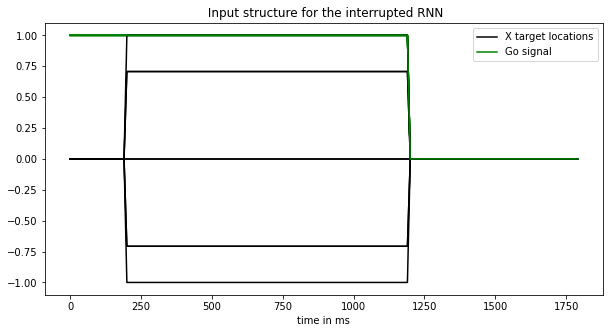

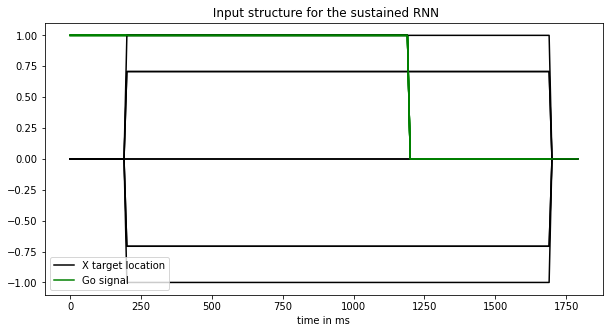

In [ ]:
#################################################### This chunk of code is used to plot all 8 x and y target locations separetly
plt.figure(figsize=(10,5))
for i in range(x_toff.shape[0]):
  if i==0:
    plt.plot(np.arange(0,x_toff.shape[1]*10,10), x_toff[i,:,0],c='k',label='X target locations')
    plt.plot(np.arange(0,x_toff.shape[1]*10,10), x_toff[i,:,2],c='g',label='Go signal')
  else:
    plt.plot(np.arange(0,x_toff.shape[1]*10,10), x_toff[i,:,0],c='k')
    plt.plot(np.arange(0,x_toff.shape[1]*10,10), x_toff[i,:,2],c='g')
plt.title(" Input structure for the interrupted RNN")
plt.xlabel('time in ms')
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
for i in range(x_ton.shape[0]): 
  if i ==0:
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), x_ton[i,:,0],c='k',label='X target location')
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), x_ton[i,:,2],c='g',label='Go signal')
  else:
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), x_ton[i,:,0],c='k')
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), x_ton[i,:,2],c='g')
plt.title(" Input structure for the sustained RNN")
plt.xlabel('time in ms')
plt.legend()
plt.show()

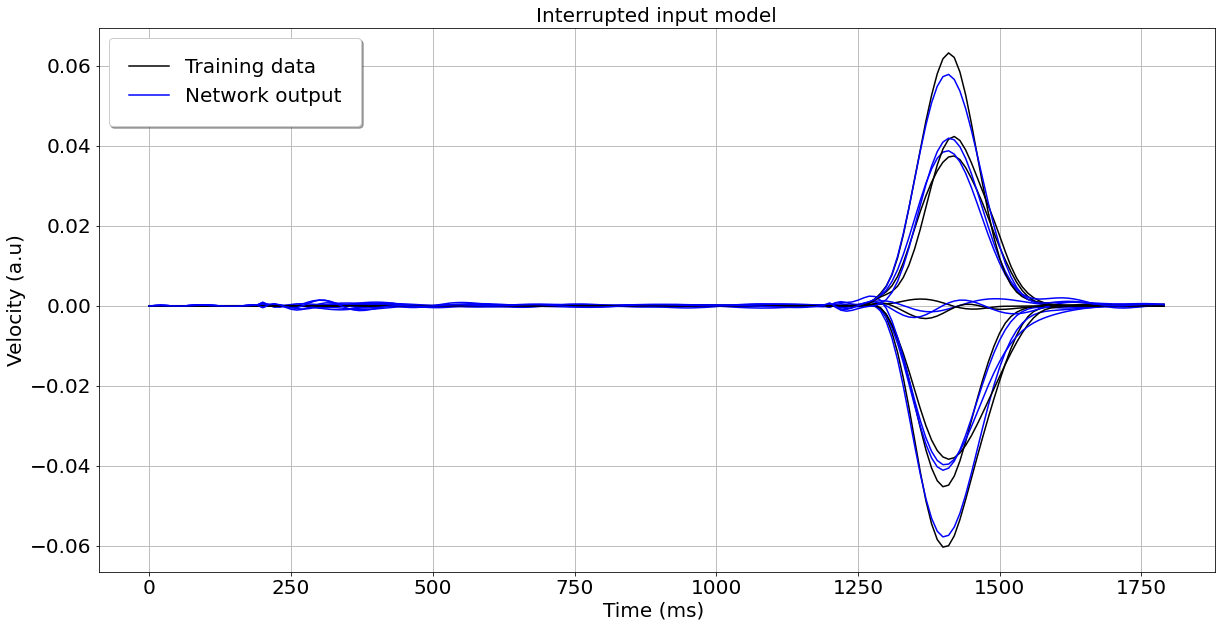

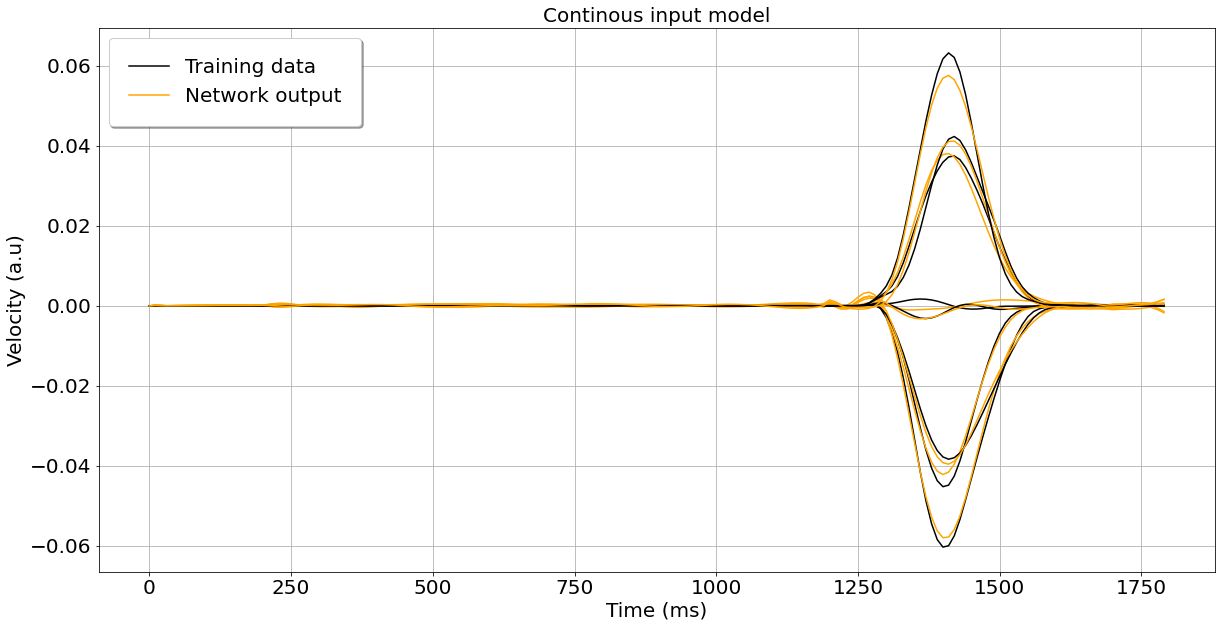

In [ ]:
############################################################## this chunk of code is used to plot the training data vs model output for the interrupted input model and the sustained input model
### t0ff model
x_velocity=0
plt.figure(figsize=(20,10))
for trial in range(y_toff.shape[0]):
  if trial ==0:
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_toff[trial,:,x_velocity],c='k',label='Training data')
    plt.plot(np.arange(0,x_ton.shape[1]*10,10),y_hat_toff[trial,:,x_velocity],c='b',label='Network output')
  else:
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_toff[trial,:,x_velocity],c='k')
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_hat_toff[trial,:,x_velocity],c='b')   
plt.title('Interrupted input model',fontsize=20)
plt.xlabel('Time (ms) ',fontsize=20)
plt.ylabel('Velocity (a.u)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()

plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=20)
plt.show()
  # plt.axis([0,y_toff.shape[1],-0.1,0.1])

### ton model
x_velocity=0
plt.figure(figsize=(20,10))
for trial in range(y_ton.shape[0]):
  if trial ==0:
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_ton[trial,:,x_velocity],c='k',label='Training data')
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_hat_ton[trial,:,x_velocity],c='orange',label='Network output')
  else:
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_ton[trial,:,x_velocity],c='k')
    plt.plot(np.arange(0,x_ton.shape[1]*10,10), y_hat_ton[trial,:,x_velocity],c='orange')   
plt.title('Continous input model',fontsize=20)
plt.xlabel('Time (ms)',fontsize=20)
plt.ylabel('Velocity (a.u)',fontsize=20)
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1, fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()
  # plt.axis([0,y_ton.shape[1],-0.1,0.1])




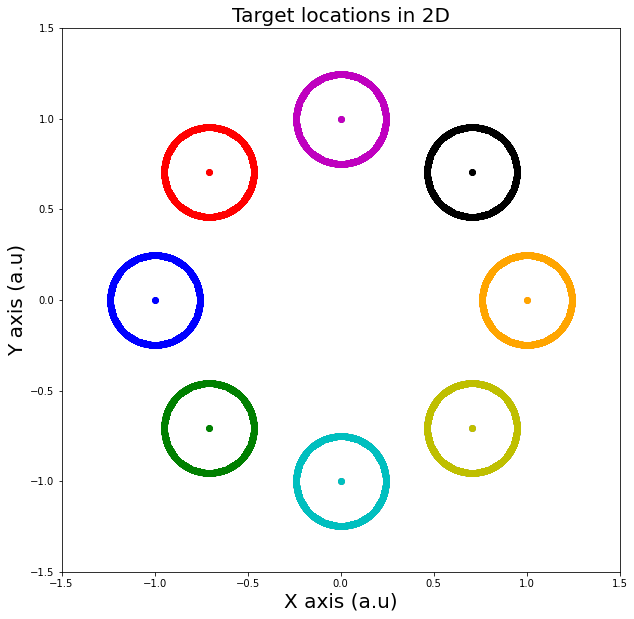

In [ ]:
######################################################################### This chuck of code plots the 8 target locations in 2D
num_of_trials= x_toff.shape[0]
c=['b','g','r','c','m','y','k','orange']
plt.figure(figsize=(10,10))
for i in range(num_of_trials):
  if i==0:
    plt.scatter(x_toff[i,30:90,0],x_toff[i,30:90,1],c=c[i],linewidths=90)
  else:
    plt.scatter(x_toff[i,30:90,0],x_toff[i,30:90,1],c=c[i],linewidths=90)
  plt.axis([-1.5,1.5,-1.5,1.5])
  plt.xlabel('X axis (a.u)', fontsize=20)
  plt.ylabel('Y axis (a.u)', fontsize=20)
  plt.title(('Target locations in 2D'), fontsize=20)
  # plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
  plt.grid()

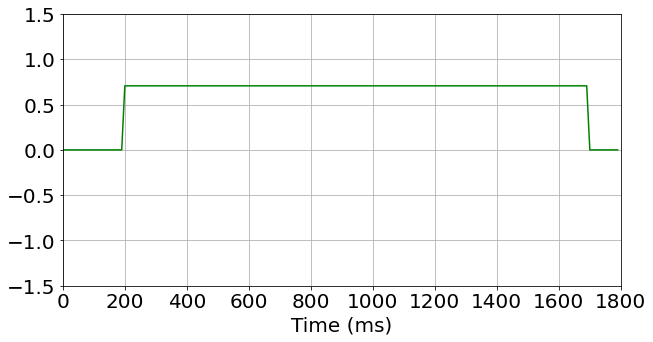

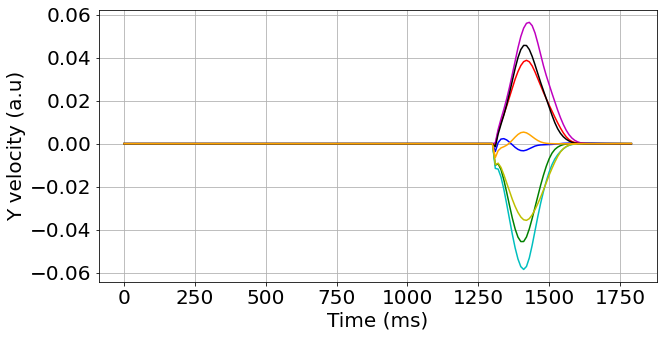

In [ ]:
################################################ accessory code
plt.figure(figsize=(10,5))
c=['b','g','r','c','m','y','k','orange']
# for i in range(x_ton.shape[0]):
plt.plot(np.arange(0,x_ton.shape[1]*10,10), x_ton[2,:,1],c='g')#[i])
    # plt.plot(np.arange(0,x_toff.shape[1]*10,10), x_toff[i,:,2],c='g')
plt.axis([0,x_ton.shape[1]*10,-1.5,1.5,])
# plt.title(" Input structure for the interrupted RNN")
plt.xlabel('Time (ms)',fontsize=20)
# plt.ylabel('X Pos (a.u)',fontsize=20)
# plt.legend()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.show()


plt.figure(figsize=(10,5))
y_toff[:,:131,1]=0
for i in range(y_toff.shape[0]): 
    plt.plot(np.arange(0,y_toff.shape[1]*10,10), y_toff[i,:,1],c=c[i])
    # plt.plot(np.arange(0,y_toff.shape[1]*10,10), y_toff[i,:,2],c='g')
# plt.title(" Input structure for the sustained RNN")
# plt.xlabel('Time in ms')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Time (ms)',fontsize=20)
plt.ylabel('Y velocity (a.u)',fontsize=20)
plt.grid()
plt.show()

################################################ accessory code

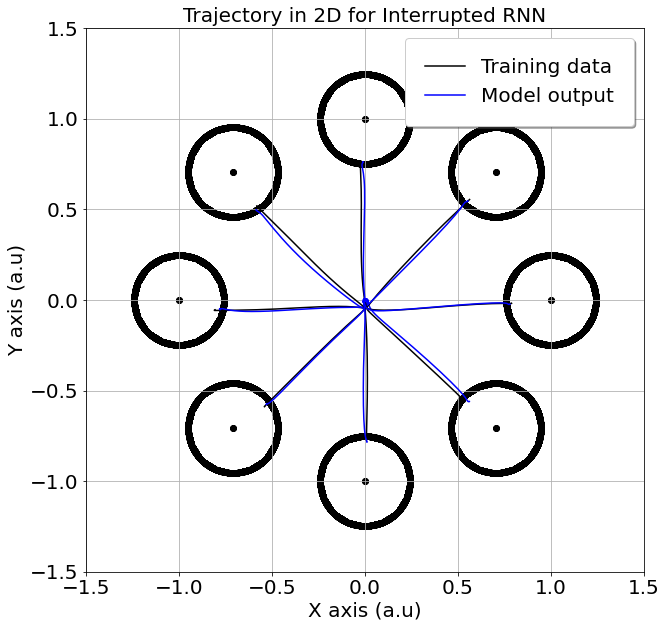

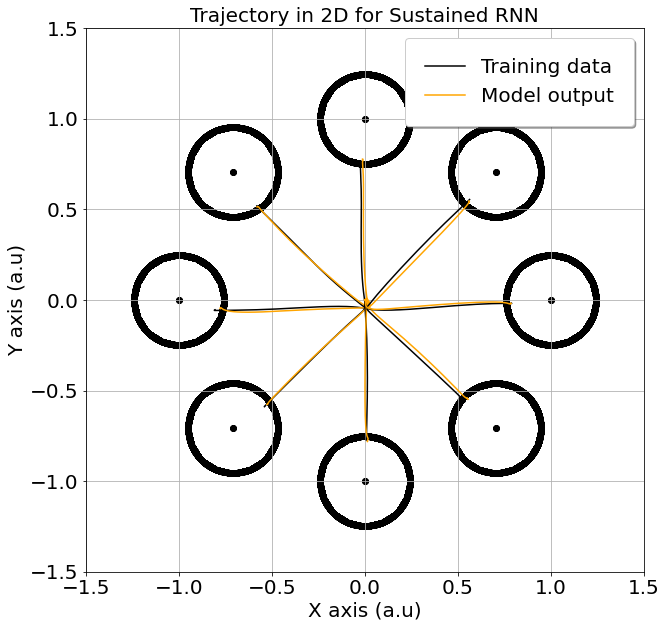

In [ ]:
# plotting training trajectory vs model output in 2D 
## toff model
y_hat_toff_wt = od.reconstruct_trajectories(y_hat_toff)
y_toff_wt = od.reconstruct_trajectories(y_toff)
plot_trials_in_2d(x_toff, y_toff_wt,y_hat_toff_wt,model_name='Interrupted RNN',color='b')

# plotting training trajectory vs model output in 2D 
## ton model
y_hat_ton_wt = od.reconstruct_trajectories(y_hat_ton)
y_ton_wt = od.reconstruct_trajectories(y_ton)
plot_trials_in_2d(x_ton, y_ton_wt,y_hat_ton_wt,model_name='Sustained RNN',color='orange')

In [40]:
sort_ind

array([199,  37,  17,  16, 120,  36,  90, 154,  34,  10,   8, 104,  88,
       185, 137,  77, 121,  67, 179,  39, 100,  43,  93,  92,  47,  48,
        49,  80,  56,  98, 106,  60,  61, 139, 146, 178, 156,  12, 166,
       168, 189,   7,  18,  31,   4,  74, 187,  68, 193,  85,  86,  89,
       177, 175, 172,  94, 169, 162, 103, 181, 114,   0,  99,  52,  38,
        35,  33,  42,  23,  19,  15,  45,  11,   9,   5, 174,  95,   2,
        96,  97,   3, 183, 107, 131, 133, 140, 165, 173, 149,  62,  66,
        57,  78,  53,  76,  75,  50, 132,  54, 148, 153, 158, 159, 163,
        20,  69, 128, 117, 130,  83,  27, 141, 142, 145, 194, 198, 150,
        55, 109, 191,  51, 164, 167, 170, 171,  71,  65, 135, 105,  64,
        32, 116, 126,  30,  29, 125, 113, 112,  59, 190, 197,  73,  21,
        41,  72, 111,  87,  79, 176,  13,  44,  58, 180, 188, 182,  91,
       184, 110,  70, 160, 118, 129,  81, 102, 134, 127, 136, 138,  26,
       101, 124, 143,  84, 195, 122, 147, 186,  28,   1, 152,  4

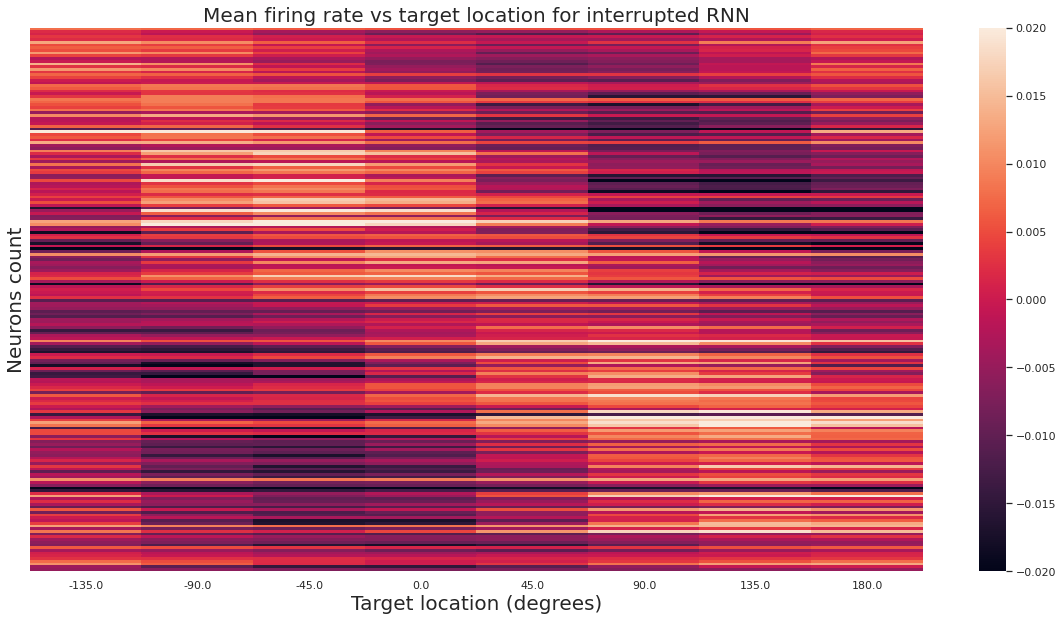

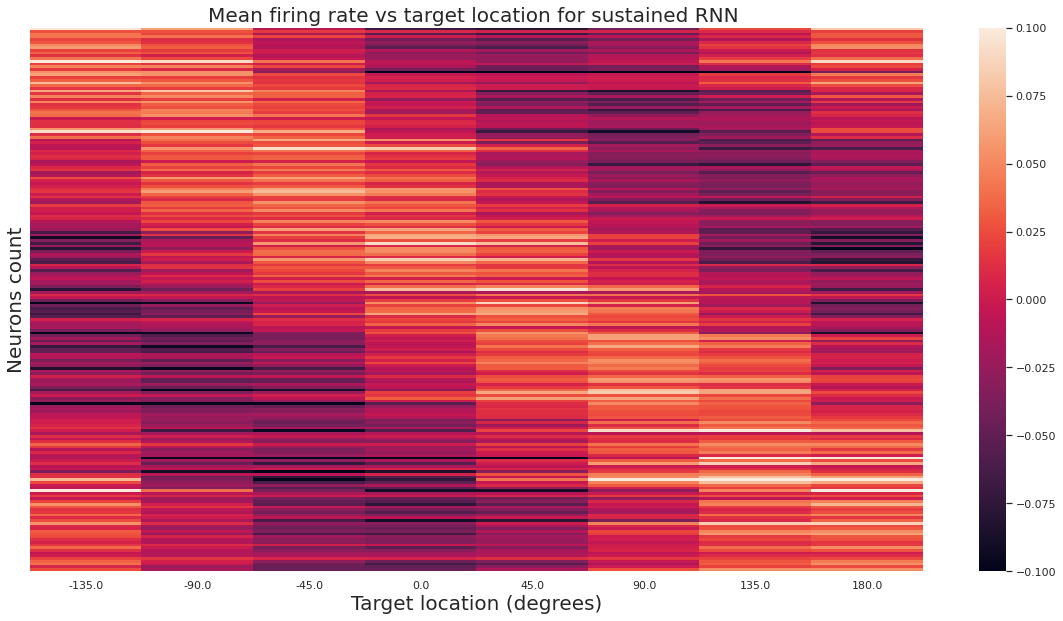

In [41]:
###########################################-------------------------------------  show single neuron tuning for toff model ------------------------------------- #################################
m_toff_firing_rates = toff_firing_rates[:,120:,:]
#find maximum firing rate for each condition for each neuron
m_toff_firing_rates = np.mean(m_toff_firing_rates,axis=1)

#calculate the location of the target in terms of polar co-ordinates
t_angles=[]
rad_t_angle=[]
for cond in range(x_toff.shape[0]):
  A = np.array((x_toff[cond,100,0], x_toff[cond,100,1]))
  t = np.arctan2(A[1],A[0])
  rad_t_angle.append(t)
  deg= np.rad2deg(t)
  t_angles.append(deg)

#sort conditions in ascending order
ind=np.argsort(t_angles)
t_angles = np.array(t_angles)[ind]
rad_t_angle = np.array(rad_t_angle)[ind]
m_toff_firing_rates = m_toff_firing_rates[ind,:]

#find which conditons has max FR for each neurons
max_ind= np.argmax(m_toff_firing_rates,axis=0)
#re-arrange neurons' order to show neurons with simillar tuning next to each other
sort_ind = np.argsort(max_ind)
m_toff_firing_rates_s = m_toff_firing_rates[:,sort_ind]

#Swap axes for the heat map plot to have neurons on y axis
m_toff_firing_rates_ss = np.swapaxes(m_toff_firing_rates_s,0,1)
#plot heat map
plt.figure(figsize=(20,10))
sns.set()
ax = sns.heatmap(m_toff_firing_rates_ss,xticklabels=t_angles, yticklabels=False,vmin=-0.02, vmax=0.02)
plt.ylabel('Neurons count',fontsize=20)
plt.xlabel('Target location (degrees)',fontsize=20)
plt.title('Mean firing rate vs target location for interrupted RNN',fontsize=20)
plt.show()

############################################################################# show single neuron tuning for ton model ################################## #################################
m_ton_firing_rates = ton_firing_rates[:,120:,:]
#find maximum firing rate for each condition for each neuron
m_ton_firing_rates = np.mean(m_ton_firing_rates,axis=1)

#calculate the location of the target in terms of polar co-ordinates
t_angles=[]
for cond in range(x_toff.shape[0]):
  A = np.array((x_toff[cond,100,0], x_toff[cond,100,1]))
  t = np.arctan2(A[1],A[0])
  deg= np.rad2deg(t)
  t_angles.append(deg)

#sort conditions in ascending order
ind=np.argsort(t_angles)
t_angles = np.array(t_angles)[ind]
m_ton_firing_rates = m_ton_firing_rates[ind,:]


#find which conditons has max FR for each neurons
max_ind= np.argmax(m_ton_firing_rates,axis=0)
#re-arrange neurons' order to show neurons with simillar tuning next to each other
sort_ind = np.argsort(max_ind)
m_ton_firing_rates_s = m_ton_firing_rates[:,sort_ind]

#Swap axes for the heat map plot to have neurons on y axis
m_ton_firing_rates_ss = np.swapaxes(m_ton_firing_rates_s,0,1)
#plot heat map
plt.figure(figsize=(20,10))
sns.set()
ax = sns.heatmap(m_ton_firing_rates_ss,xticklabels=t_angles, yticklabels=False, vmin=-0.1, vmax=0.1)
plt.ylabel('Neurons count',fontsize=20)
plt.xlabel('Target location (degrees)',fontsize=20)
plt.title('Mean firing rate vs target location for sustained RNN ',fontsize=20)
plt.show()


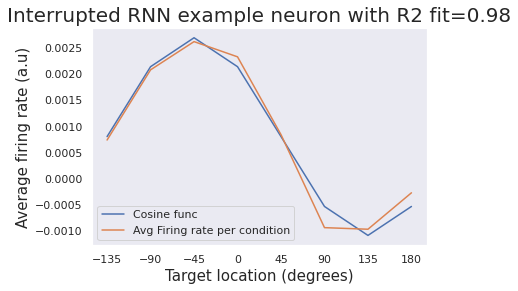

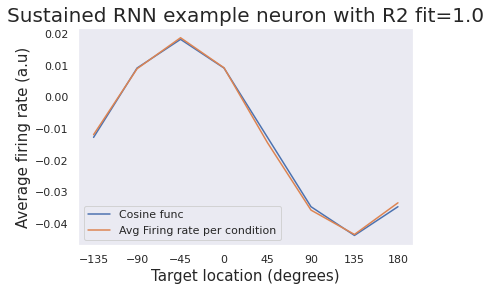

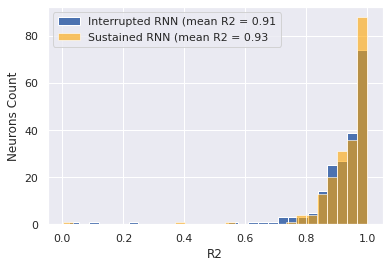

In [54]:
###########################################-------------------------------------  calc and show single neuron tuning for toff model ------------------------------------- #################################
m_toff_firing_rates = toff_firing_rates[:,120:,:]
#find maximum firing rate for each condition for each neuron
m_toff_firing_rates = np.mean(m_toff_firing_rates,axis=1)

#calculate the location of the target in terms of polar co-ordinates
t_angles=[]
rad_t_angle=[]
for cond in range(x_toff.shape[0]):
  A = np.array((x_toff[cond,100,0], x_toff[cond,100,1]))
  t = np.arctan2(A[1],A[0])
  rad_t_angle.append(t)
  deg= np.rad2deg(t)
  t_angles.append(deg)

#sort firing rates in ascending order of target locations
ind=np.argsort(t_angles)
t_angles = np.array(t_angles)[ind]
rad_t_angle = np.array(rad_t_angle)[ind]
m_toff_firing_rates = m_toff_firing_rates[ind,:]
mfr_pd_toff = np.argmax(m_toff_firing_rates, axis=0)

#find each neurons' preferred direction and store it in n_pd_toff 
n_pd_toff=[]
for i in range(mfr_pd_toff.shape[0]):
  for j in range(rad_t_angle.shape[0]):
    if mfr_pd_toff[i] == j:
      n_pd_toff.append([])
      n_pd_toff[i].append(rad_t_angle[j])
n_pd_toff= np.array(n_pd_toff)

### cosine model according to Geogoopolous et al. (1988)
#construct array to store the cosine function
cosine_func_toff = np.zeros((m_toff_firing_rates.shape[0],m_toff_firing_rates.shape[1]))
r2_toff = []
for i in range(n_pd_toff.shape[0]):
  def cos_func(M, amplitude, offset): #we need to define each neurons' preferred direction for the calculation each time
      return offset+(amplitude * np.cos((n_pd_toff[i] - M)))
  # fit each neruon's fr accross conditions to a cosine tuning model
  popt, pcov = curve_fit(cos_func, rad_t_angle, m_toff_firing_rates[:,i])
  # get the actual cosine model values for popt (the fitting parameters for amplitude and offset above) for each conditon
  k = cos_func(rad_t_angle, popt[0], popt[1])
  #store the cosine tuning function return values for each conditions
  cosine_func_toff[:,i]=k
  #calculate the how well the cosine tuning values fit with the neurons' avg FR per condition (R2 value)
  r2_toff.append(r2_score(list(m_toff_firing_rates[:,i]), cosine_func_toff[:,i] ))

#plot an example neuron's raw tuning and cosine function return values
plt.plot(t_angles, cosine_func_toff[:,0], label='Cosine func')
plt.plot(t_angles, m_toff_firing_rates[:,0], label='Avg Firing rate per condition')
plt.xticks(t_angles)
plt.legend()
plt.xlabel('Target location (degrees)',fontsize=15)
plt.ylabel('Average firing rate (a.u)',fontsize=15)
plt.title('Interrupted RNN example neuron with R2 fit=' + str(np.round(r2_toff[0],2)),fontsize=20)
plt.grid()
plt.show()




# # ############################################################################# show single neuron tuning for ton model ################################## #################################
m_ton_firing_rates = ton_firing_rates[:,120:,:]
#find maximum firing rate for each condition for each neuron
m_ton_firing_rates = np.mean(m_ton_firing_rates,axis=1)

#calculate the location of the target in terms of polar co-ordinates
t_angles=[]
rad_t_angle=[]
for cond in range(x_ton.shape[0]):
  A = np.array((x_ton[cond,100,0], x_ton[cond,100,1]))
  t = np.arctan2(A[1],A[0])
  rad_t_angle.append(t)
  deg= np.rad2deg(t)
  t_angles.append(deg)

#sort firing rates according to ascending order of target locations
ind=np.argsort(t_angles)
t_angles = np.array(t_angles)[ind]
rad_t_angle = np.array(rad_t_angle)[ind]
m_ton_firing_rates = m_ton_firing_rates[ind,:]
mfr_pd = np.argmax(m_ton_firing_rates, axis=0)
n_pd=[]
for i in range(mfr_pd.shape[0]):
  for j in range(rad_t_angle.shape[0]):
    if mfr_pd[i] == j:
      n_pd.append([])
      n_pd[i].append(rad_t_angle[j])
n_pd= np.array(n_pd)

### cosine model according to Geogoopolous et al. (1988)
#construct array to store the cosine function
cosine_func_ton = np.zeros((m_ton_firing_rates.shape[0],m_ton_firing_rates.shape[1]))
r2_ton = []
for i in range(0,n_pd.shape[0]):
  def cos_func(M, amplitude, offset): #we need to define each neurons' preferred direction for the calculation each time
      return offset+(amplitude * np.cos((n_pd[i] - M)))
  # fit each neruon's fr accross conditions to a cosine tuning model
  popt, pcov = curve_fit(cos_func, rad_t_angle, m_ton_firing_rates[:,i])
  # get the actual cosine model values for popt (the fitting parameters for amplitude and offset above) for each conditon
  k = cos_func(rad_t_angle, popt[0], popt[1])
  #store the cosine tuning function return values for each conditions
  cosine_func_ton[:,i]=k
  #calculate the how well the cosine tuning values fit with the neurons' avg FR per condition (R2 value)
  r2_ton.append(r2_score(m_ton_firing_rates[:,i], cosine_func_ton[:,i] ))

#plot an example neuron's raw tuning and cosine function return values
plt.plot(t_angles, cosine_func_ton[:,0], label='Cosine func')
plt.plot(t_angles, m_ton_firing_rates[:,0], label='Avg Firing rate per condition')
plt.xticks(t_angles)
plt.legend()
plt.xlabel('Target location (degrees)',fontsize=15)
plt.ylabel('Average firing rate (a.u)',fontsize=15)
plt.title('Sustained RNN example neuron with R2 fit=' + str(np.round(r2_ton[0],2)),fontsize=20)
plt.grid()
plt.show()



#########################################################################################################
#plot histgram of tuning fit r2 scores for both models

bins=30
plt.hist(r2_toff, density=False, bins=bins,label='Interrupted RNN (mean R2 = '+ str(np.round(np.mean(r2_toff),2))) 
plt.hist(r2_ton, density=False, bins=bins,alpha=0.6,label='Sustained RNN (mean R2 = '+ str(np.round(np.mean(r2_ton),2)),color='orange')
plt.ylabel('Neurons Count')
plt.xlabel('R2')

# plt.axis([-1,1,0,100])
plt.legend()
plt.show()

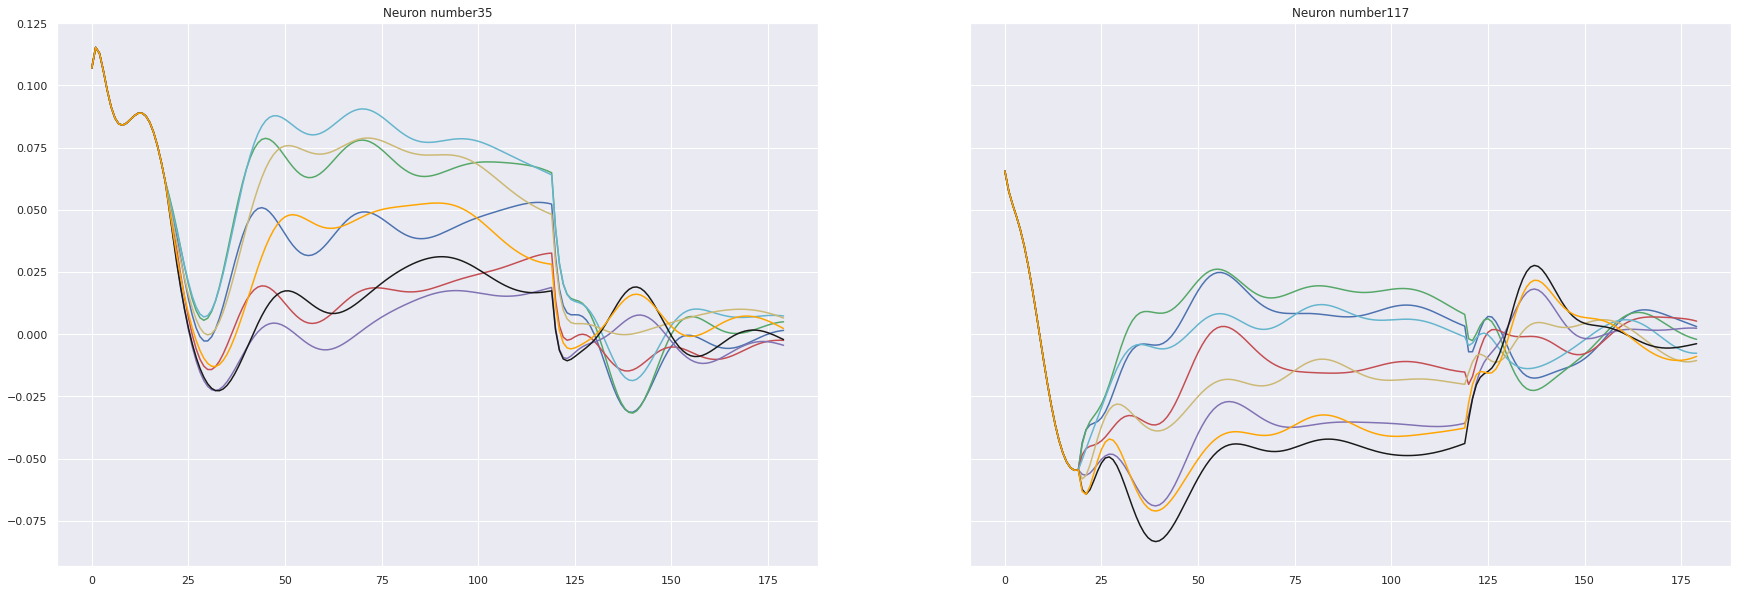

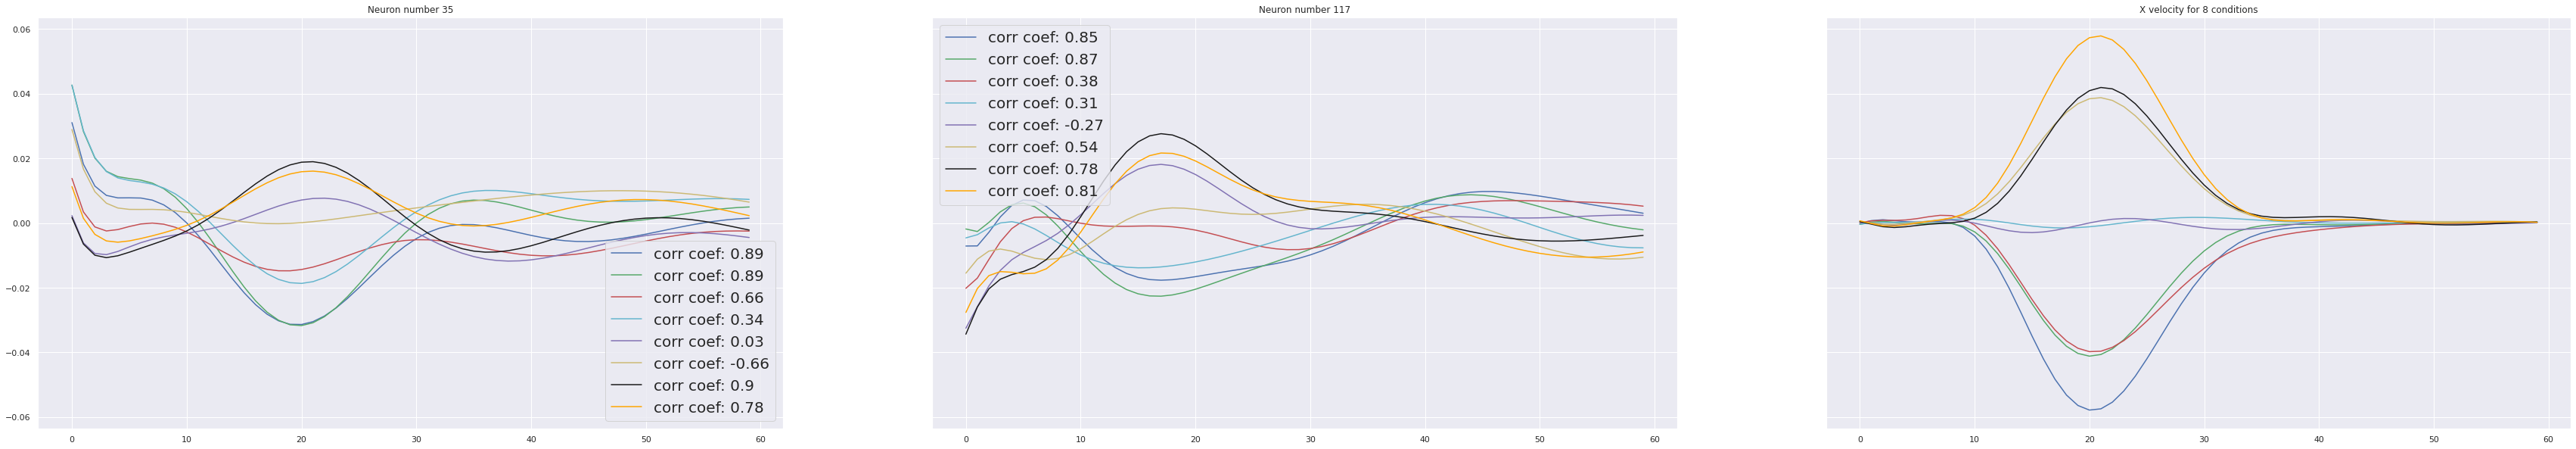

In [59]:
############################################################################################## for interrupted input model  #########################################################################################
### calc correlations between neurons FR and velocity output for toff model
k_ns_toff=[]
k_ns_toff_random=[]
for neuron in range(toff_firing_rates.shape[2]):
  corr=np.corrcoef(toff_firing_rates[:,120:,neuron],y_hat_toff[:,120:,0])
  k_ns_toff.append([])
  k_ns_toff_random.append([])
  for i in range(0,8):
    k_ns_toff[neuron].append (np.round(corr[i,i+8],2))
    rand = np.random.randint(8,16)
    #stores the corellation between a given neuron i and some random condition
    k_ns_toff_random[neuron].append (np.round(corr[i,rand],2))


#############this block is to show which neurons have the highest total correlation between FR and Velocity output accross all conditions toff model
# #summ all correlations of conditions accross each neuron
# l=[]
# for i in k_ns_toff:
#   sum=0
#   for j in i:
#     sum += abs(j)
#   l.append(sum)

# #find neurons with strong correlation accross all conditions
# neuron_list=[]
# limit=4.5 #lower limit of correlation sum (neurons with total correlations above this value will be ploted)
# for i in range(len(l)):
#   if l[i]>limit or l[i]<-limit :
#     neuron_list.append(i)

# #plot those neurons
# c=['b','g','r','c','m','y','k','orange']
# for neuron in neuron_list:
#   f,axs = plt.subplots(1,2,figsize=(10, 10),sharey=True)
#   for condition in range(toff_firing_rates.shape[0]):
#     axs[0].plot(toff_firing_rates[condition,120:,neuron],c=c[condition])
#     axs[1].plot(y_hat_toff[condition,120:,0],c=c[condition],label=('corr coef: '+str(k_ns_toff[neuron][condition])))
#     # plt.plot(y_hat_toff[condition,:,1],c='y')
#   axs[0].title.set_text('Neuron number' + str(neuron))
#   # axs[0].xlabel('Time in 10ms increments')
#   axs[1].legend()
#   axs[1].title.set_text('X velocity for 8 conditions')
#   plt.show()

#####################################
##plot certain neruons and the correlation of their movment epoch with the velocity output
N1=35 #neuron to plot
N2=117 #neuron to plot

#plot neuron 35 and 117 full epoch
c=['b','g','r','c','m','y','k','orange']
f,axs = plt.subplots(1,2,figsize=(30, 10),sharey=True)
for condition in range(toff_firing_rates.shape[0]):
  axs[0].plot(toff_firing_rates[condition,:,N1],c=c[condition])
  axs[1].plot(toff_firing_rates[condition,:,N2],c=c[condition])
axs[0].title.set_text('Neuron number' + str(N1))
axs[1].title.set_text('Neuron number' + str(N2))
plt.show()

#plot non-shifted movment epoch of specific neurons
c=['b','g','r','c','m','y','k','orange']
f,axs = plt.subplots(1,3,figsize=(60, 10),sharey=True)
for condition in range(toff_firing_rates.shape[0]):
  axs[0].plot(toff_firing_rates[condition,120:,N1],c=c[condition],label=('corr coef: '+str(k_ns_toff[N1][condition])))
  axs[1].plot(toff_firing_rates[condition,120:,N2],c=c[condition],label=('corr coef: '+str(k_ns_toff[N2][condition])))
  axs[2].plot(y_hat_toff[condition,120:,0],c=c[condition])
axs[0].title.set_text('Neuron number ' + str(N1))
axs[1].title.set_text('Neuron number ' + str(N2))
axs[1].legend(fontsize=20)
axs[0].legend(fontsize=20)
axs[2].title.set_text('X velocity for 8 conditions')
plt.show()

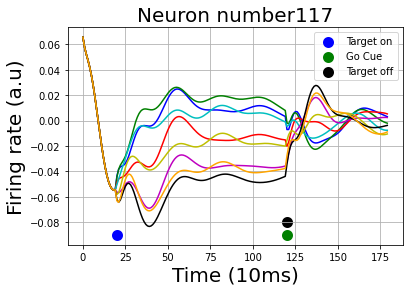

In [ ]:
# plot firing rate of one neuron
N2=117
c=['b','g','r','c','m','y','k','orange']

for condition in range(toff_firing_rates.shape[0]):
  plt.plot(toff_firing_rates[condition,:,N2],c=c[condition])
plt.scatter(20,-0.09,label='Target on', marker='o',c='b',linewidths=5)
plt.scatter(120,-0.09,label='Go Cue', marker='o',c='g',linewidths=5)
plt.scatter(120,-0.08,label='Target off', marker='o',c='k',linewidths=5)

plt.title('Neuron number' + str(N2), fontsize=20)
plt.xlabel('Time (10ms)', fontsize=20)
plt.ylabel('Firing rate (a.u)', fontsize=20)
plt.legend()
plt.grid()
plt.show()

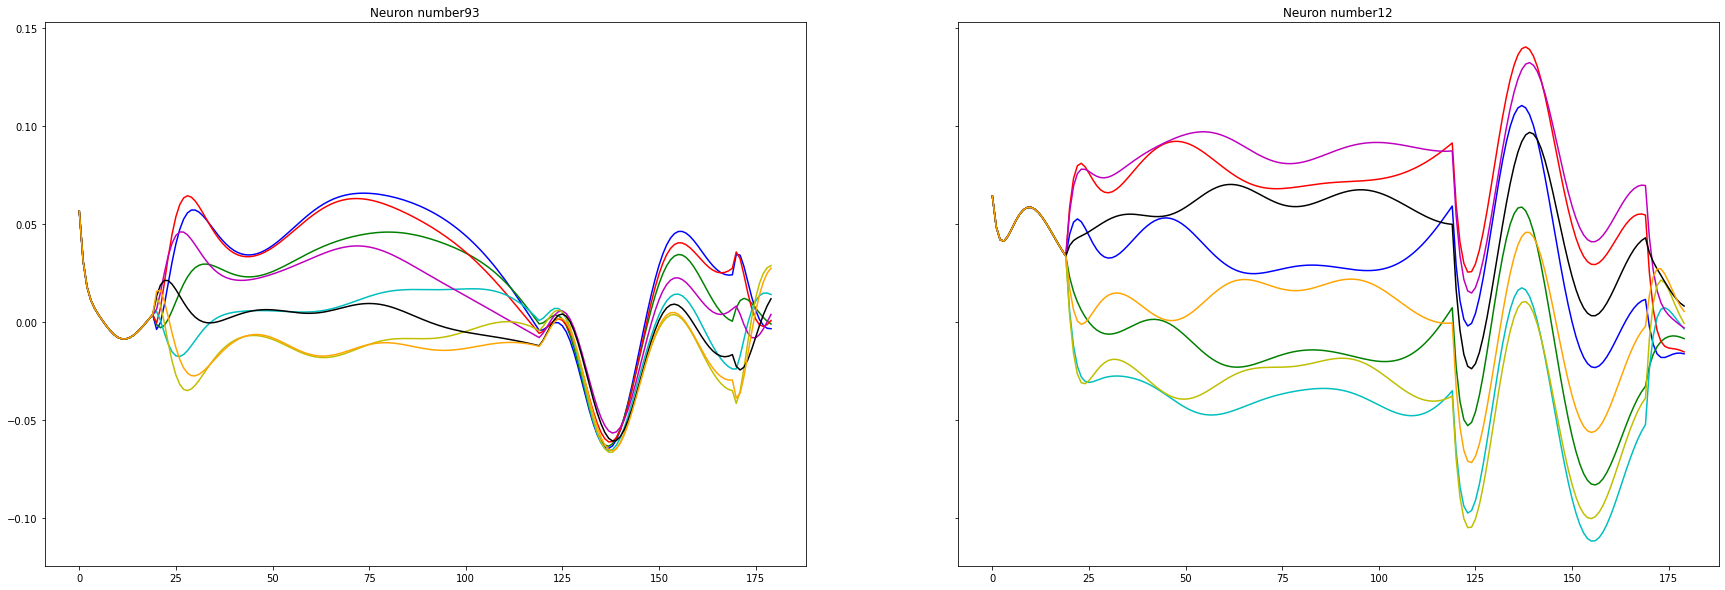

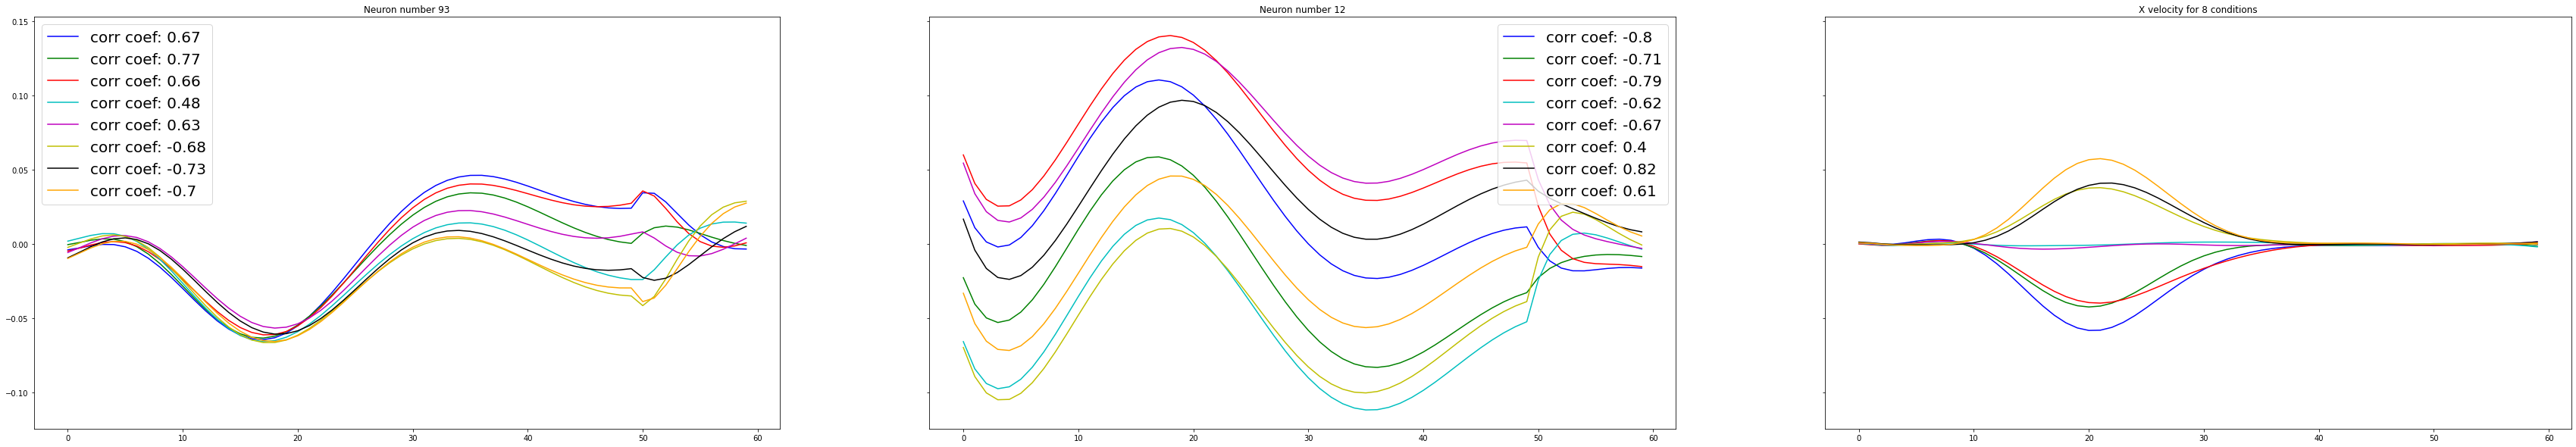

In [ ]:
############################################################################################## for sustained input model  #########################################################################################
### calc correlations between neurons FR and velocity output for ton model
k_ns_ton=[]
k_ns_ton_random=[]
for neuron in range(ton_firing_rates.shape[2]):
  corr=np.corrcoef(ton_firing_rates[:,120:,neuron],y_hat_ton[:,120:,0])
  k_ns_ton.append([])
  k_ns_ton_random.append([])
  for i in range(0,8):
    k_ns_ton[neuron].append (np.round(corr[i,i+8],2))
    rand= np.random.randint(8,16)
    k_ns_ton_random[neuron].append (np.round(corr[i,rand],2))

#############this block is to show which neurons have the highest total correlation between FR and Velocity output accross all conditions toff model
# #summ all correlations of all conditions accross each neuron
# l=[]
# for i in k_ns_ton:
#   sum=0
#   for j in i:
#     sum += abs(j)
#   l.append(sum)

# #find neurons with strong correlation accross all conditions
# neuron_list=[]
# limit=5.3 #lower limit of correlation sum (neurons with total correlations above this value will be ploted)
# for i in range(len(l)):
#   if l[i]>limit or l[i]<-limit :
#     neuron_list.append(i)

# #plot those neurons
# c=['b','g','r','c','m','y','k','orange']
# for neuron in neuron_list:
#   f,axs = plt.subplots(1,2,figsize=(10, 10),sharey=True)
#   for condition in range(ton_firing_rates.shape[0]):
#     axs[0].plot(ton_firing_rates[condition,120:,neuron],c=c[condition])
#     axs[1].plot(y_hat_ton[condition,120:,0],c=c[condition],label=('corr coef: '+str(k_ns_ton[neuron][condition])))
#     # plt.plot(y_hat_toff[condition,:,1],c='y')
#   axs[0].title.set_text('Neuron number' + str(neuron))
#   # axs[0].xlabel('Time in 10ms increments')
#   axs[1].legend()
#   axs[1].title.set_text('X velocity for 8 conditions')
#   plt.show()

###############################################################
##plot certain neruons and the correlation of their movment epoch with the velocity output
N1=93 
N2=12  

#plot neuron full epoch
c=['b','g','r','c','m','y','k','orange']
f,axs = plt.subplots(1,2,figsize=(30, 10),sharey=True)
for condition in range(ton_firing_rates.shape[0]):
  axs[0].plot(ton_firing_rates[condition,:,N1],c=c[condition])
  axs[1].plot(ton_firing_rates[condition,:,N2],c=c[condition])
axs[0].title.set_text('Neuron number' + str(N1))
axs[1].title.set_text('Neuron number' + str(N2))
# axs[0].xlabel('Time in 10ms increments')
plt.show()

#plot non-shifted movment epoch of specific neurons in ton model
c=['b','g','r','c','m','y','k','orange']
f,axs = plt.subplots(1,3,figsize=(60, 10),sharey=True)
for condition in range(ton_firing_rates.shape[0]):
  axs[0].plot(ton_firing_rates[condition,120:,N1],c=c[condition],label=('corr coef: '+str(k_ns_ton[N1][condition])))
  axs[1].plot(ton_firing_rates[condition,120:,N2],c=c[condition],label=('corr coef: '+str(k_ns_ton[N2][condition])))
  axs[2].plot(y_hat_ton[condition,120:,0],c=c[condition])
  # plt.plot(y_hat_toff[condition,:,1],c='y')
axs[0].title.set_text('Neuron number ' + str(N1))
axs[1].title.set_text('Neuron number ' + str(N2))
# axs[0].xlabel('Time in 10ms increments')
axs[1].legend( fontsize=20)
axs[0].legend( fontsize=20)
axs[2].title.set_text('X velocity for 8 conditions')
plt.show()


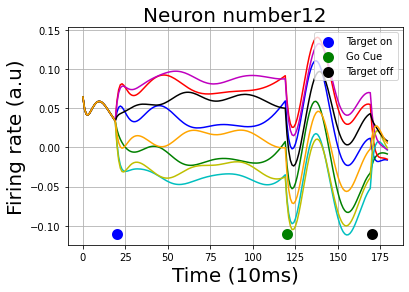

In [ ]:
# plot one particular neuron from the sustained input RNN
N2=12

#plot neuron full epoch
c=['b','g','r','c','m','y','k','orange']

for condition in range(ton_firing_rates.shape[0]):
  plt.plot(ton_firing_rates[condition,:,N2],c=c[condition])


plt.title('Neuron number' + str(N2))

plt.scatter(20,-0.11,label='Target on', marker='o',c='b',linewidths=5)
plt.scatter(120,-0.11,label='Go Cue', marker='o',c='g',linewidths=5)
plt.scatter(170,-0.11,label='Target off', marker='o',c='k',linewidths=5)

plt.title('Neuron number' + str(N2), fontsize=20)
plt.xlabel('Time (10ms)', fontsize=20)
plt.ylabel('Firing rate (a.u)', fontsize=20)
plt.legend(loc='upper right')
plt.grid()
plt.show()

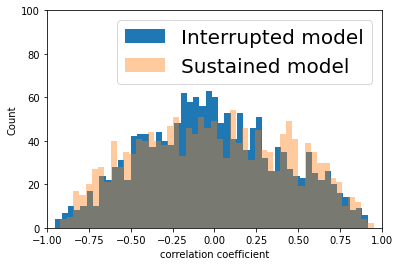

In [ ]:
####### plot the distribution of correlation coeffcient values of the each neurons' firing rate with the velocity for each model
plt.hist(rk_ns_toff, density=False, bins=50,label='Interrupted model')
plt.hist(rk_ns_ton, density=False,alpha=0.4, bins=50,label='Sustained model')
plt.ylabel('Count')
plt.xlabel('correlation coefficient')
plt.axis([-1,1,0,100])
plt.legend(fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


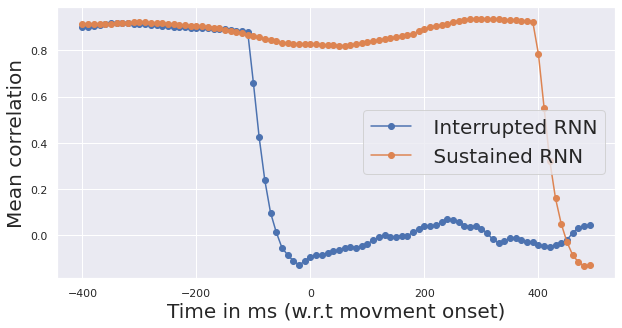

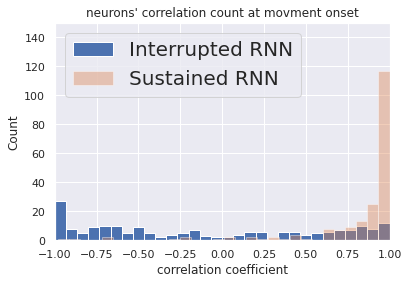

In [64]:
############################################# this block is to show that correlation doesnt change accross prep and movment epoch for ton model but it does as it should for toff model #############################################
######################## Recreating fig 4 from churchland et al. (2010)
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------########################################
#calculate the movment epoch average firing rate of each neuron for each condition
all_toff_firing_rates = copy(toff_firing_rates[:,:,:])
#get the average firing rate of each neuron during the prepratory period for each condition
a_toff_firing_rates =np.average(toff_firing_rates[:,20:120,:],axis=1)
#construct an array of equal size to all_toff_firing_rates but contains avergae prep neural tuning calculated above for each neuron
avg_prep_toff_firing_rates = np.ones((all_toff_firing_rates.shape[0], all_toff_firing_rates.shape[1], all_toff_firing_rates.shape[2]))
for i in range(avg_prep_toff_firing_rates.shape[0]):
  for j in range(avg_prep_toff_firing_rates.shape[2]):
    avg_prep_toff_firing_rates[i,:,j] = a_toff_firing_rates[i,j]

## swap axis in order to correlate each neurons avg tunning during the prep period with all time steps
avg_prep_toff_firing_rates= np.swapaxes(avg_prep_toff_firing_rates,0,1)
all_toff_firing_rates    = np.swapaxes(all_toff_firing_rates,0,1)

## calculate correlations
k_toff=[]
time_len= all_toff_firing_rates.shape[0]
for neuron in range(all_toff_firing_rates.shape[2]):
  corr=np.corrcoef(all_toff_firing_rates[:,:,neuron], avg_prep_toff_firing_rates[:,:,neuron])
  k_toff.append([])
  for i in range(0,time_len):
    k_toff[neuron].append (np.round(corr[i,i+time_len],2))
k_toff = np.array(k_toff)
#calculate the mean correlation accross all neurons as a function of time
avg_k_toff = np.average(k_toff,axis=0)

############-----------------------------------------------------------------------------------------    For T-on model -----------------------------------------------------------------------------------------########################################
#calculate the movment epoch average firing rate of each neuron for each condition
all_ton_firing_rates = ton_firing_rates[:,:,:]
#get the average firing rate of each neuron during the prepratory period for each condition
a_ton_firing_rates =np.average(ton_firing_rates[:,20:120,:],axis=1)
#construct an array of equal size to all_toff_firing_rates but contains avergae prep neural tuning calculated above for each neuron
avg_prep_ton_firing_rates=np.ones((all_ton_firing_rates.shape[0], all_ton_firing_rates.shape[1], all_ton_firing_rates.shape[2]))
for i in range(avg_prep_ton_firing_rates.shape[0]):
  for j in range(avg_prep_ton_firing_rates.shape[2]):
    avg_prep_ton_firing_rates[i,:,j] = a_ton_firing_rates[i,j]

## swap axis in order to correlate each neurons avg tunning during the prep period with all time steps
avg_prep_ton_firing_rates= np.swapaxes(avg_prep_ton_firing_rates,0,1)
all_ton_firing_rates    = np.swapaxes(all_ton_firing_rates,0,1)

k_ton=[]
time_len= all_ton_firing_rates.shape[0]
for neuron in range(all_ton_firing_rates.shape[2]):
  corr=np.corrcoef(all_ton_firing_rates[:,:,neuron], avg_prep_ton_firing_rates[:,:,neuron])
  k_ton.append([])
  for i in range(0,time_len):
    k_ton[neuron].append (np.round(corr[i,i+time_len],2))
k_ton = np.array(k_ton)
#calculate the mean correlation accross all neurons as a function of time
avg_k_ton = np.average(k_ton,axis=0)

############ plot the mean correlation vs time for BOTH models
fig, ax = plt.subplots(figsize=[10,5])
x_axis = np.arange(-400,500,10)
ax.plot(x_axis, avg_k_toff[90:],marker='o', label=' Interrupted RNN')
ax.plot(x_axis, avg_k_ton[90:],marker='o', label=' Sustained RNN')
ax.set_xlabel('Time in ms (w.r.t movment onset)',fontsize=20)
ax.set_ylabel('Mean correlation',fontsize=20)
ax.legend(fontsize=20)
plt.show()

############ plot histogram of neural correlation for ton and toff models at movment onset
bins=30
plt.hist(k_toff[:,130], density=False, bins=bins,label='Interrupted RNN')  # density=False would make counts
plt.hist(k_ton[:,130], density=False,alpha=0.4, bins=bins,label='Sustained RNN') 
plt.ylabel('Count')
plt.xlabel('correlation coefficient')
plt.axis([-1,1,0,150])
plt.title("neurons' correlation count at movment onset")
plt.legend(fontsize=20)
plt.show()

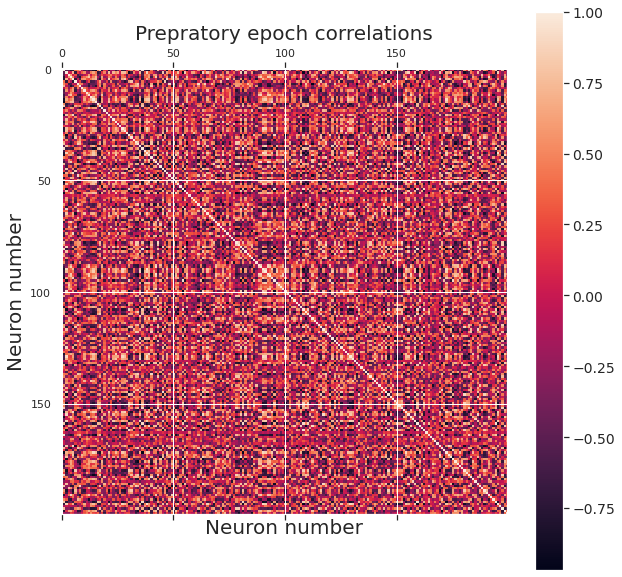

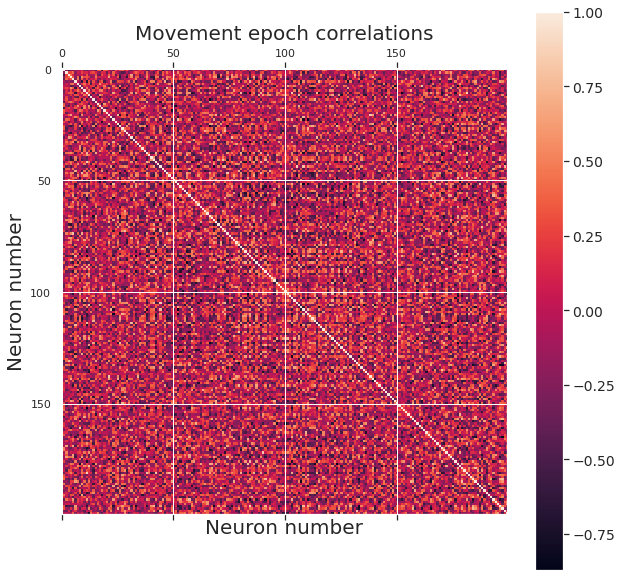

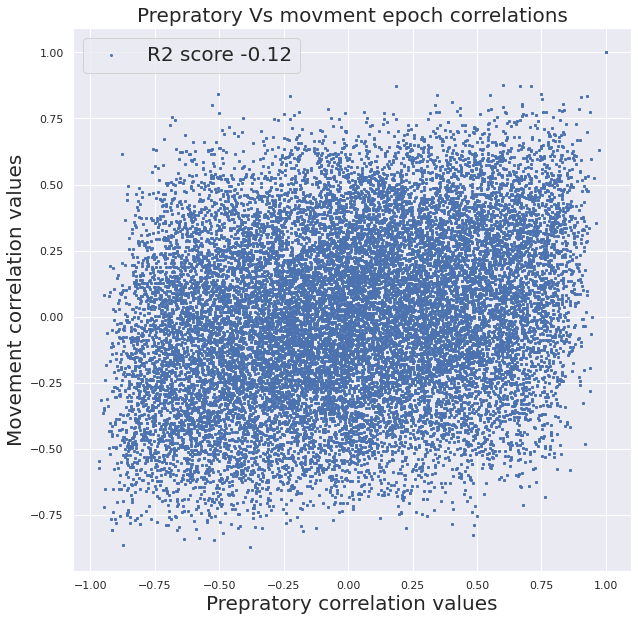

In [68]:
############################################# this block is to show the pairwise correlation between neurons in the prep epoch and movement epich separetly #############################################
######################## Recreating fig 3 from Elsayed et al. (2016)
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------#######################

#align the firing rates such that each neurons' response accross all conditions lie in one column
aligned_toff_prep_fr =align_trials(toff_firing_rates[:,20:120,:])
aligned_toff_mov_fr =align_trials(toff_firing_rates[:,120:,:])
#convert to dataframe to use pandas pirwise correation
df=pd.DataFrame(aligned_toff_prep_fr)
df1=pd.DataFrame(aligned_toff_mov_fr)
cor_before_gocue=df.corr()
cor_after_gocue=df1.corr()

# plot prepratory correlation matrix
f = plt.figure(figsize=(10, 10))
plt.matshow(cor_before_gocue, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Prepratory epoch correlations',fontsize=20)
plt.xlabel('Neuron number',fontsize=20)
plt.ylabel('Neuron number',fontsize=20)
plt.show()
# plot movement correlation matrix
f = plt.figure(figsize=(10, 10))
plt.matshow(cor_after_gocue, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Movement epoch correlations',fontsize=20)
plt.xlabel('Neuron number',fontsize=20)
plt.ylabel('Neuron number',fontsize=20)

############ calc R2 for fit of preperatory correlation values to movement correlaton values
##### convert back to numpy array
cor_before_gocue=np.array(cor_before_gocue)
cor_after_gocue=np.array(cor_after_gocue)
#### calc R2 value for fit of preperatory correlation values to movement correlaton values
prep_to_mov_r2 = r2(cor_before_gocue, cor_after_gocue)

############ plot prepratory correlations against movement correlations
plt.figure(figsize=(10,10))
plt.scatter(cor_before_gocue,cor_after_gocue,marker='.',linewidths=0.002,label=('R2 score '+ str(np.round(prep_to_mov_r2,2))))
plt.title('Prepratory Vs movment epoch correlations',fontsize=20)
plt.xlabel('Prepratory correlation values',fontsize=20)
plt.ylabel('Movement correlation values',fontsize=20)
plt.legend(fontsize=20)
plt.show()

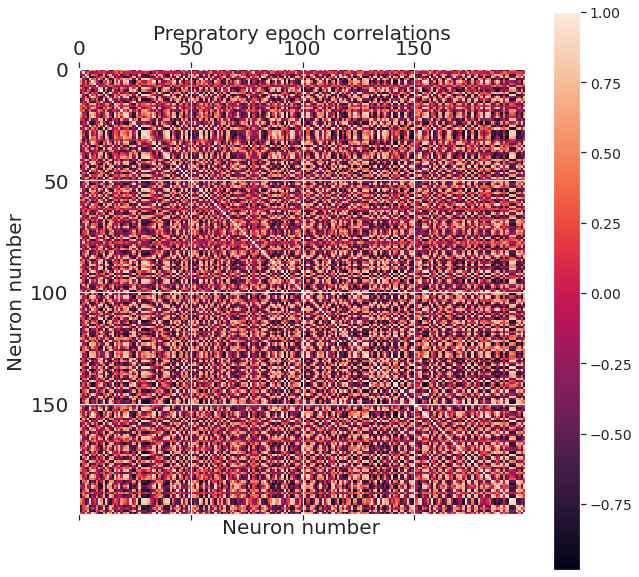

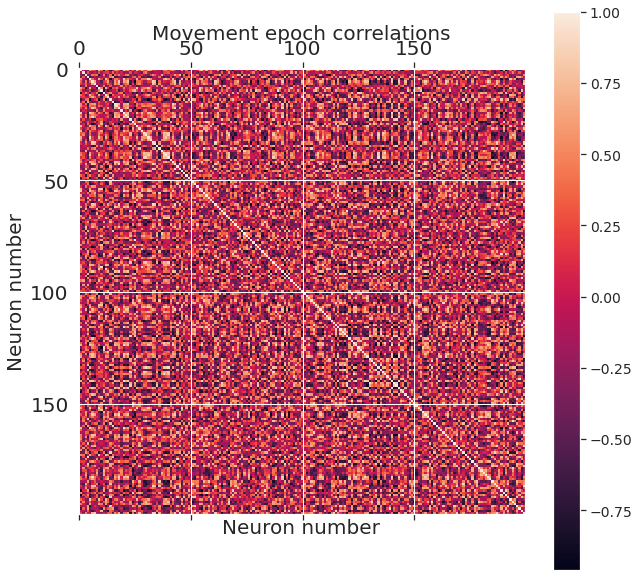

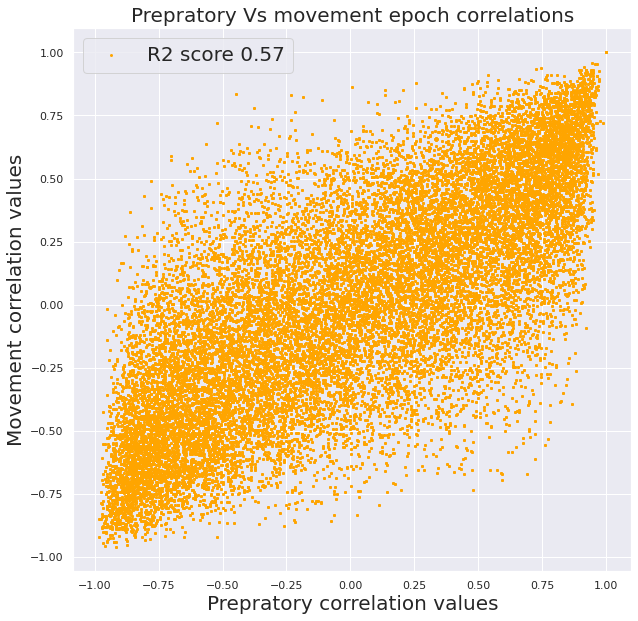

In [69]:
############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------#######################
#align the firing rates such that each neurons' response accross all conditions lie in one column
aligned_ton_prep_fr =align_trials(ton_firing_rates[:,20:120,:])
aligned_ton_mov_fr =align_trials(ton_firing_rates[:,120:,:])
#convert to dataframe to use pandas pirwise correation
df=pd.DataFrame(aligned_ton_prep_fr)
df1=pd.DataFrame(aligned_ton_mov_fr)
cor_before_gocue=df.corr()
cor_after_gocue=df1.corr()

# plot prepratory correlation matrix
f = plt.figure(figsize=(10, 10))
plt.matshow(cor_before_gocue, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Prepratory epoch correlations',fontsize=20)
plt.xlabel('Neuron number',fontsize=20)
plt.ylabel('Neuron number',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
# plot movement correlation matrix
f = plt.figure(figsize=(10, 10))
plt.matshow(cor_after_gocue, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Movement epoch correlations',fontsize=20)
plt.xlabel('Neuron number',fontsize=20)
plt.ylabel('Neuron number',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

############ calc R2 for the correlation before and after the go cue
#convert to numpy arrays
cor_before_gocue=np.array(cor_before_gocue)
cor_after_gocue=np.array(cor_after_gocue)
#### calc R2 value for fit of preperatory correlation values to movement correlaton values
prep_to_mov_r2 = r2(cor_before_gocue,cor_after_gocue)

############ plot correlations of correlations
plt.figure(figsize=(10,10))
cor_before_gocue=np.array(cor_before_gocue)
cor_after_gocue=np.array(cor_after_gocue)
plt.scatter(cor_before_gocue,cor_after_gocue,marker='.',linewidths=0.002,c='orange',label=('R2 score '+ str(np.round(prep_to_mov_r2,2))))
plt.title('Prepratory Vs movement epoch correlations',fontsize=20)
plt.xlabel('Prepratory correlation values',fontsize=20)
plt.ylabel('Movement correlation values',fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

Text(0, 0.5, 'Angle in degrees')

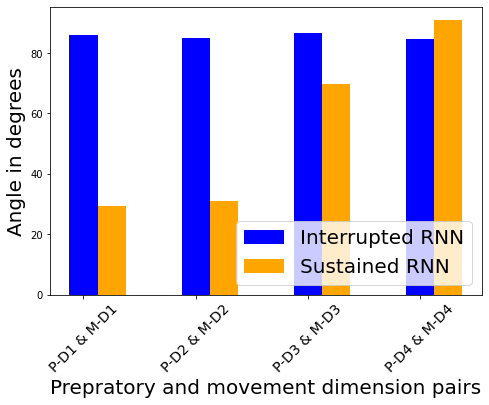

In [ ]:
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------###################
##### this block is to calculate the angles between each prepratory principal and another movment principal component (they should be orthogonal according to Elsayed at al. 2016)
n_components =4 #number of pre-specified principal components
#### find preperatory principal components (300ms period starting 500 ms prior to movement onset)
upper_limit=int(1100/dt)
lower_limit=int(800/dt)

#use population response to find principal components
#this function aligns each neurons response such that each column contains the concacted firing rates of that neuron for each condition
#this functions also subtracts the mean firing rate acrross all conditions for each time step from each time step as per Lara et al. (2018)
pca_ready_prep_epoch = prep_data_for_pca(toff_firing_rates[:,lower_limit:upper_limit,:])

pca = PCA(n_components)
# find prepratory principal components
prep_epoch = pca.fit(pca_ready_prep_epoch)
# get principal axes
toff_prep_dimensions = pca.components_
##########################################################
#### find movement principal components (from movment onset + 200 ms)
upper_limit=int(1500/dt)
lower_limit=int(1300/dt)

#use population response to find principal components
#this function aligns each neurons response such that each column contains the concacted firing rates of that neuron for each condition
#this functions also subtracts the mean firing rate acrross all conditions for each time step from each time step as per Lara et al. (2018)
pca_ready_move_epoch = prep_data_for_pca(toff_firing_rates[:,lower_limit:upper_limit,:])

pca = PCA(n_components)
# find movement principal components
prep_epoch= pca.fit(pca_ready_move_epoch)
# get principal axes
toff_movement_dimensions = pca.components_

##############  find angle between Prep and Movment axes using cos(theta)= (P.M)/(|p|x|M|)
angles_toff=[]
for i in range(toff_prep_dimensions.shape[0]):
  p= toff_prep_dimensions[i]
  m= toff_movement_dimensions[i]
  d= np.dot(p,m)
  mag= np.linalg.norm(p) * np.linalg.norm(m)
  #convert angle in radians to degrees
  angles_toff.append(np.degrees(np.arccos(d/mag)))

############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------#########
#### find preperatory principal components (300ms period starting 500 ms prior to movement onset)
upper_limit=int(1100/dt)
lower_limit=int(800/dt)

#use population response to find principal components
#this function aligns each neurons response such that each column contains the concacted firing rates of that neuron for each condition
#this functions also subtracts the mean firing rate acrross all conditions for each time step from each time step as per Lara et al. (2018)
pca_ready_prep_epoch = prep_data_for_pca(ton_firing_rates[:,lower_limit:upper_limit,:])

pca = PCA(n_components)
# find prep principal components
prep_epoch= pca.fit(pca_ready_prep_epoch)
# get principal axes
ton_prep_dimensions = pca.components_

#################
#### find movement principal components (from movment onset + 200 ms)
upper_limit=int(1500/dt)
lower_limit=int(1300/dt)

#use population response to find principal components
#this function aligns each neurons response such that each column contains the concacted firing rates of that neuron for each condition
#this functions also subtracts the mean firing rate acrross all conditions for each time step from each time step as per Lara et al. (2018)
pca_ready_move_epoch = prep_data_for_pca(ton_firing_rates[:,lower_limit:upper_limit,:])

pca = PCA(n_components)
# find movement principal components
move_epoch= pca.fit(pca_ready_move_epoch)
# get principal axes
ton_movement_dimensions = pca.components_

#################  find angle between Prep and Movment axes using cos(theta)= (P.M)/(|p|x|M|)
angles_ton=[]
for i in range(ton_prep_dimensions.shape[0]):
  p= ton_prep_dimensions[i]
  m= ton_movement_dimensions[i]
  d= np.dot(p,m)
  mag= np.linalg.norm(p) * np.linalg.norm(m)
  angles_ton.append(np.degrees(np.arccos(d/mag)))

################## plot angles between PCs for each model
X = np.arange(len(angles_ton))
labels = ['P-D1 & M-D1', 'P-D2 & M-D2', 'P-D3 & M-D3', 'P-D4 & M-D4']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, angles_toff, color = 'b', width = 0.25, tick_label=labels, label='Interrupted RNN')
ax.bar(X + 0.25, angles_ton, color = 'orange', width = 0.25, label='Sustained RNN')
ax.legend(loc='lower right',fontsize=20)
plt.xticks(fontsize=14, rotation = 45 )
ax.set_xlabel('Prepratory and movement dimension pairs',fontsize=20)
ax.set_ylabel('Angle in degrees',fontsize=20)

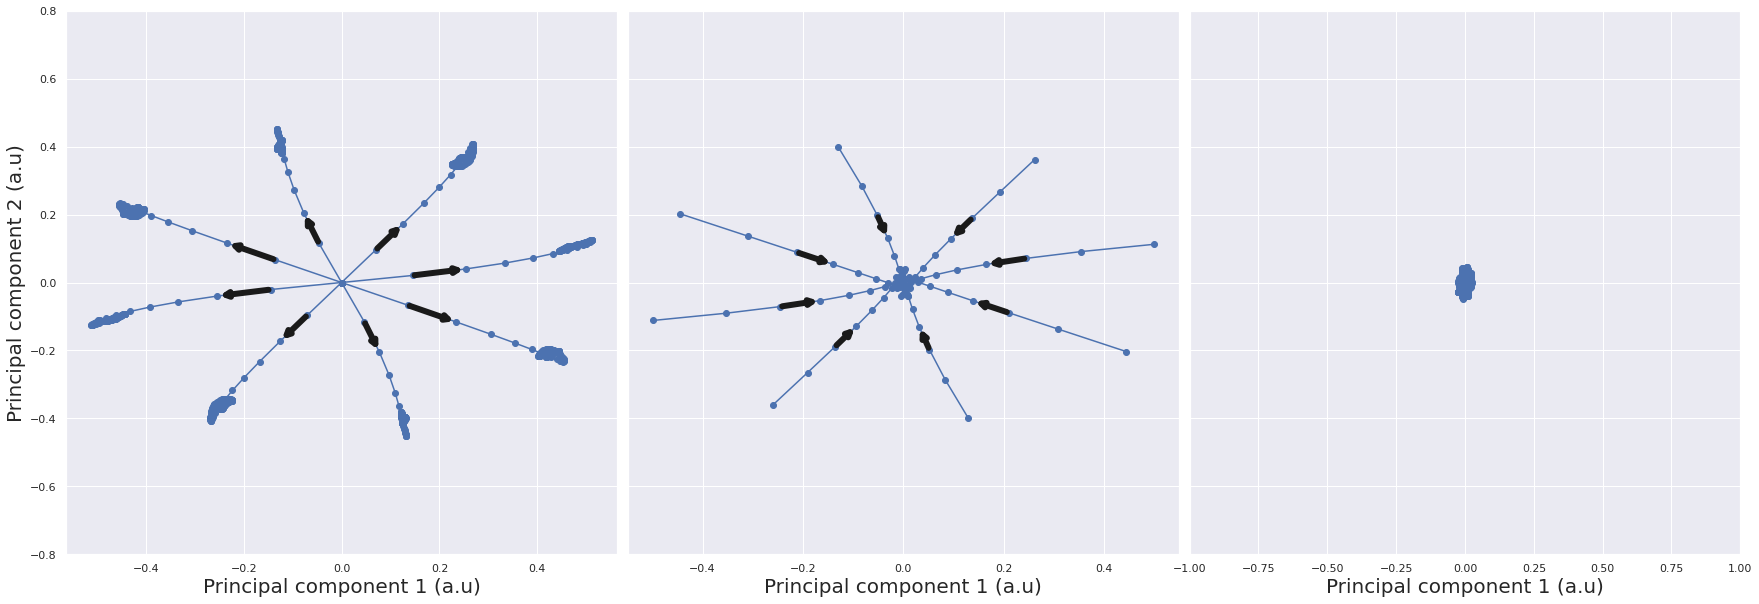

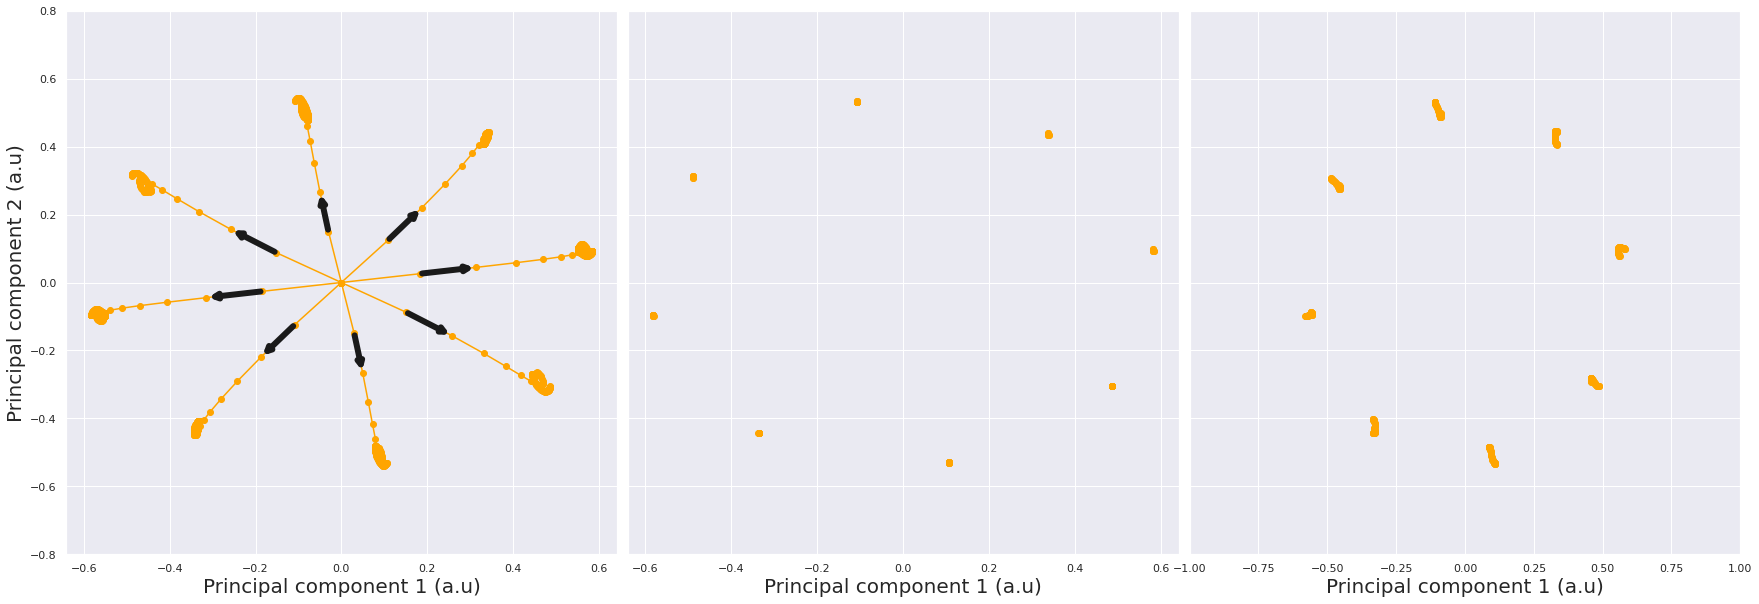

Text(0.5, 1.0, 'Sustained RNN')

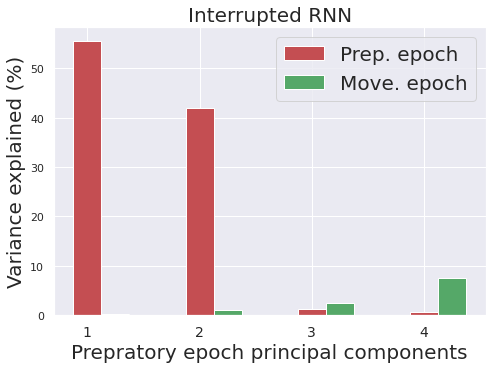

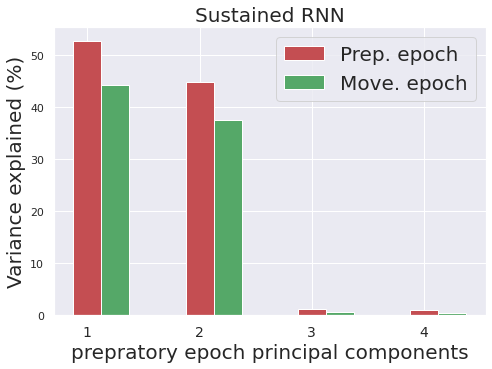

In [73]:
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------###############
##### this block is to find the prepratory manifold and project the whole neral population response onto it recreating ELsayed at al. (2016) (figure 6)
### define prepratory and movment epochs
##movement epoch = (from movment onset + 200 ms)
##prep epoch = (300ms period starting 500 ms prior to movement onset)
prep_lower_limit=int(800/dt) 
prep_upper_limit=int(1100/dt) 
move_upper_limit=int(1500/dt) 
move_lower_limit=int(1300/dt) 
n_components = 4

#use neural population respone of the corosponding epoch
p_epoch = prep_data_for_pca(toff_firing_rates[:,prep_lower_limit:prep_upper_limit,:])
m_epoch = prep_data_for_pca(toff_firing_rates[:,move_lower_limit:move_upper_limit,:])

full_epoch_centred_fr = prep_data_for_pca(toff_firing_rates[:,:,:])
t_len=int(full_epoch_centred_fr.shape[0]/toff_firing_rates.shape[0])


pca = PCA(n_components)
# find prepratory principal components 
prep_epoch= pca.fit(p_epoch)

# calculate the variance captured in movemnet and prep epochs by the prepratory principal components
Prep_var_exp_by_pd_toff = pca.explained_variance_ratio_*100
move_var_exp_by_pd_toff = explained_variance(m_epoch, pca)*100
# project the whole population response onto the prepratory manifold
full_pc_fr_toff=pca.transform(full_epoch_centred_fr)
# convert the principal components back to (conditons x time steps x principal components) for easier plotting
projected_traj_toff=align_trials(full_pc_fr_toff,de_align=True)

#########plot the projected population response (neural trajectories for 8 conditons) onto the prepratory dimensions
f,axs = plt.subplots(1,3,figsize=(30, 10),sharey=True)

#plot the neural trajectories with respect to target onset
for i in range(projected_traj_toff.shape[0]):
  axs[0].plot(projected_traj_toff[i,19:120,0],projected_traj_toff[i,19:120,1], c='b',marker='o')
  axs[0].annotate("", xy=(projected_traj_toff[i,21,0],projected_traj_toff[i,21,1]), xytext=(projected_traj_toff[i,20,0],projected_traj_toff[i,20,1]),arrowprops=dict(arrowstyle="->",lw=6,color='k'))
axs[0].set_xlabel('Principal component 1 (a.u)',fontsize=20)
axs[0].set_ylabel('Principal component 2 (a.u)',fontsize=20)

#plot the neural trajectories with respect to go cue
for i in range(projected_traj_toff.shape[0]):
  axs[1].plot(projected_traj_toff[i,119:130,0],projected_traj_toff[i,119:130,1], c='b',marker='o')
  axs[1].annotate("", xy=(projected_traj_toff[i,122,0],projected_traj_toff[i,122,1]), xytext=(projected_traj_toff[i,121,0],projected_traj_toff[i,121,1]),arrowprops=dict(arrowstyle="->",lw=6,color='k'))
axs[1].set_xlabel('Principal component 1 (a.u)',fontsize=20)


#plot the neural trajectories with respect to movement onset
for i in range(projected_traj_toff.shape[0]):
  axs[2].plot(projected_traj_toff[i,130:170,0],projected_traj_toff[i,130:170,1], c='b',marker='o')
axs[2].set_xlabel('Principal component 1 (a.u)',fontsize=20)

plt.axis([-1,1,-0.8, 0.8])
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------###############

#define the neural population respone of the corosponding epoch
p_epoch = prep_data_for_pca(ton_firing_rates[:,prep_lower_limit:prep_upper_limit,:])
m_epoch = prep_data_for_pca(ton_firing_rates[:,move_lower_limit:move_upper_limit,:])

#use avg non-pert firing rates to prep fr of prep epoch and the whole epoch
p_epoch_centred_fr = prep_data_for_pca(ton_firing_rates[:,:,:])
t_len=int(p_epoch_centred_fr.shape[0]/ton_firing_rates.shape[0])

pca = PCA(n_components)
# find prepratory principal components 
prep_epoch= pca.fit(p_epoch)

# calculate the variance captured in movemnet and prep epochs by the prepratory principal components
Prep_var_exp_by_pd_ton = pca.explained_variance_ratio_*100
move_var_exp_by_pd_ton = explained_variance(m_epoch, pca)*100
# project the whole population response onto the prepratory manifold
full_pc_fr_ton=pca.transform(p_epoch_centred_fr)

# convert the principal components back to (conditons x time steps x principal components) for easier plotting
projected_traj_ton=align_trials(full_pc_fr_ton,de_align=True)

#########plot the projected population response (neural trajectories for 8 conditons) onto the prepratory dimensions
#plot the neural trajectories with respect to target onset
f,axs = plt.subplots(1,3,figsize=(30, 10),sharey=True)
# plt.figure(figsize=(10,10))
for i in range(projected_traj_ton.shape[0]):
  axs[0].plot(projected_traj_ton[i,19:120,0],projected_traj_ton[i,19:120,1], c='orange',marker='o')
  axs[0].annotate("", xy=(projected_traj_ton[i,21,0],projected_traj_ton[i,21,1]), xytext=(projected_traj_ton[i,20,0],projected_traj_ton[i,20,1]),arrowprops=dict(arrowstyle="->",lw=6,color='k'))
axs[0].set_xlabel('Principal component 1 (a.u)',fontsize=20)
axs[0].set_ylabel('Principal component 2 (a.u)',fontsize=20)

#plot the neural trajectories with respect to go cue
for i in range(projected_traj_ton.shape[0]):
  axs[1].plot(projected_traj_ton[i,119:130,0],projected_traj_ton[i,119:130,1], c='orange',marker='o')
axs[1].set_xlabel('Principal component 1 (a.u)',fontsize=20)

#plot the neural trajectories with respect to movement onset
for i in range(projected_traj_ton.shape[0]):
  axs[2].plot(projected_traj_ton[i,130:169,0],projected_traj_ton[i,130:169,1], c='orange',marker='o')
axs[2].set_xlabel('Principal component 1 (a.u)',fontsize=20)

plt.axis([-1,1,-0.8, 0.8])
plt.subplots_adjust(wspace=0.02, hspace=0)
plt.show()

################# This chunk plots the percentage of variance capture by the prepratory principal components in the prepratory and movement epoch separetly for BOTH Models
###### this recreats figure 4-a in Elsayed et al. (2016)
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------###############
X = np.arange(1,Prep_var_exp_by_pd_toff.shape[0]+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Prep_var_exp_by_pd_toff, color = 'r', width = 0.25, label='Prep. epoch')
ax.bar(X + 0.25, move_var_exp_by_pd_toff, color = 'g', width = 0.25, label='Move. epoch')
ax.legend(loc='upper right',fontsize=20)
plt.xticks(X, fontsize=14)
ax.set_xlabel('Prepratory epoch principal components',fontsize=20)
ax.set_ylabel('Variance explained (%)',fontsize=20)
ax.set_title('Interrupted RNN',fontsize=20)
############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------###############
X = np.arange(1,Prep_var_exp_by_pd_toff.shape[0]+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, Prep_var_exp_by_pd_ton, color = 'r', width = 0.25, label='Prep. epoch')
ax.bar(X + 0.25, move_var_exp_by_pd_ton, color = 'g', width = 0.25, label='Move. epoch')
ax.legend(loc='upper right',fontsize=20)
plt.xticks(X, fontsize=14)
ax.set_xlabel('prepratory epoch principal components',fontsize=20)
ax.set_ylabel('Variance explained (%)',fontsize=20)
ax.set_title('Sustained RNN',fontsize=20)

Text(0.5, 1.0, 'Sustained RNN')

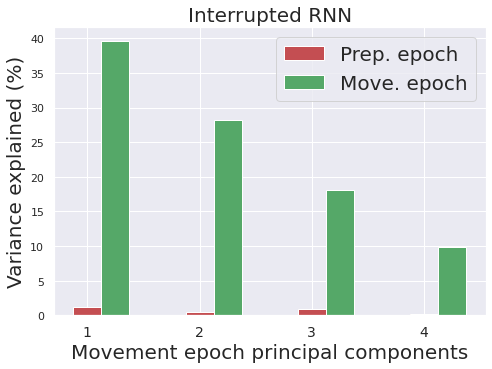

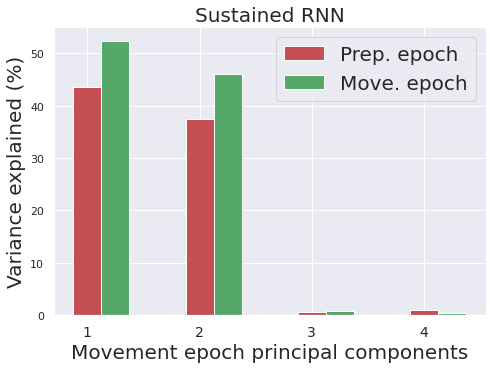

In [72]:
################# This chunk calculates the percentage of variance capture by the prepratory movement components in the prepratory and movement epoch separetly for BOTH Models
###### this recreats figure 4-b in Elsayed et al. (2016)
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------###############
### define prepratory and movment epochs
##movement epoch = (from movment onset + 200 ms)
##prep epoch = (300ms period starting 500 ms prior to movement onset)
prep_lower_limit=int(800/dt) 
prep_upper_limit=int(1100/dt) 
move_upper_limit=int(1500/dt) 
move_lower_limit=int(1300/dt) 
n_components = 4

#define the neural population respone of the corosponding epoch
p_epoch = prep_data_for_pca(toff_firing_rates[:,prep_lower_limit:prep_upper_limit,:])
m_epoch = prep_data_for_pca(toff_firing_rates[:,move_lower_limit:move_upper_limit,:])

pca = PCA(n_components)
# find movement principal components
move_epoch= pca.fit(m_epoch)

# calculate the variance captured in movemnet and prep epochs by the movement principal components
move_var_exp_by_md_toff = pca.explained_variance_ratio_*100
prep_var_exp_by_md_toff = explained_variance(p_epoch, pca)*100
############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------###############
#use avg non-pert firing rates to find principal components
p_epoch = prep_data_for_pca(ton_firing_rates[:,prep_lower_limit:prep_upper_limit,:])
m_epoch = prep_data_for_pca(ton_firing_rates[:,move_lower_limit:move_upper_limit,:])

#use avg non-pert firing rates to prep fr of prep epoch and the whole epoch
p_epoch_centred_fr = prep_data_for_pca(ton_firing_rates[:,:,:])

pca = PCA(n_components)
# find principal components with the epoch segment from target-on to 100ms before go cue
move_epoch= pca.fit(m_epoch)
var_explained_ton = pca.explained_variance_ratio_
# find how much variance of movemnet epoch and prep epoch separetly is captured by prep dimensions
move_var_exp_by_md_ton = pca.explained_variance_ratio_*100
prep_var_exp_by_md_ton = explained_variance(p_epoch, pca)*100

################# This chunk plots the percentage of variance capture by the movement principal components in the prepratory and movement epoch separetly for BOTH Models
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------###############
X = np.arange(1,move_var_exp_by_md_toff.shape[0]+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, prep_var_exp_by_md_toff, color = 'r', width = 0.25, label='Prep. epoch')
ax.bar(X + 0.25, move_var_exp_by_md_toff, color = 'g', width = 0.25, label='Move. epoch')
ax.legend(loc='upper right',fontsize=20)
plt.xticks(X, fontsize=14)
ax.set_xlabel('Movement epoch principal components',fontsize=20)
ax.set_ylabel('Variance explained (%)',fontsize=20)
ax.set_title('Interrupted RNN',fontsize=20)

############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------###############
X = np.arange(1,Prep_var_exp_by_pd_toff.shape[0]+1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, prep_var_exp_by_md_ton, color = 'r', width = 0.25, label='Prep. epoch')
ax.bar(X + 0.25, move_var_exp_by_md_ton, color = 'g', width = 0.25, label='Move. epoch')
ax.legend(loc='upper right',fontsize=20)
plt.xticks(X, fontsize=14)
ax.set_xlabel('Movement epoch principal components',fontsize=20)
ax.set_ylabel('Variance explained (%)',fontsize=20)
ax.set_title('Sustained RNN',fontsize=20)

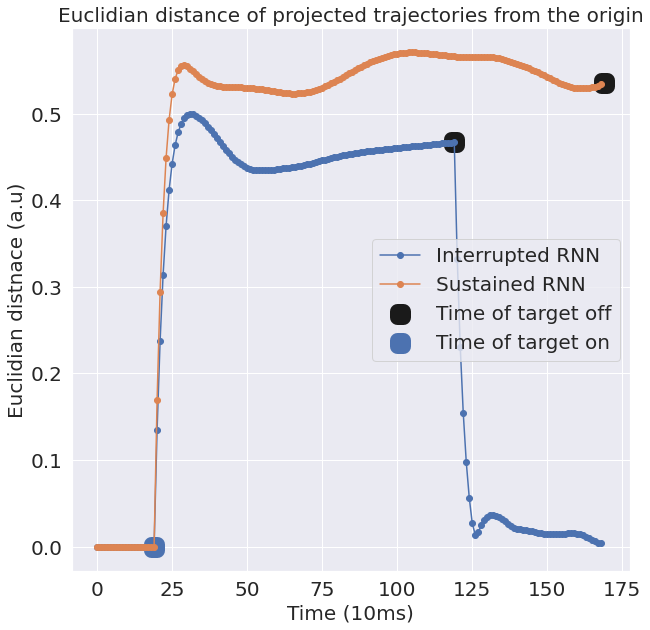

In [ ]:
########### this block is to calc the average euclidiqan distance accross all conditions from the origin in the prepratory manifold
############-----------------------------------------------------------------------------------------   For T-off model -----------------------------------------------------------------------------------------###############
### calculate the euclidian distance at each time step and store it in dist
dist=[]
for cond in range(projected_traj_toff.shape[0]):
  dist.append([])
  for i in range(projected_traj_toff.shape[1]):
    p = np.array((projected_traj_toff[cond,i,0], projected_traj_toff[cond,i,1]))
    dist[cond].append(np.linalg.norm(p))
dist_toff=np.array(dist)
# calc the average dist accross the 8 conditions as function of time
dist_toff = np.average(dist_toff,axis=0)
############-----------------------------------------------------------------------------------------   For T-on model -----------------------------------------------------------------------------------------###############
### calculate the euclidian distance at each time step and store it in dist
full_pc_fr_ton_dealigned = align_trials(full_pc_fr_ton , de_align=True)
dist=[]
for cond in range(full_pc_fr_ton_dealigned.shape[0]):
  dist.append([])
  for i in range(full_pc_fr_ton_dealigned.shape[1]):
    p = np.array((full_pc_fr_ton_dealigned[cond,i,0], full_pc_fr_ton_dealigned[cond,i,1]))
    dist[cond].append(np.linalg.norm(p))
dist_ton=np.array(dist)
# calc the average dist accross the 8 conditions as function of time
dist_ton = np.average(dist_ton,axis=0)
###########
##plot euclidian distance for Both models in the prepratory subspace
plt.figure(figsize=(10,10))
plt.plot(dist_toff[:169],label='Interrupted RNN',marker='o')
plt.scatter(119, dist_toff[119],marker='s',color='k',linewidths=15, label='Time of target off')
plt.scatter(19, dist_toff[19],marker='s',color='b',linewidths=15, label='Time of target on')
plt.plot(dist_ton[:169],label='Sustained RNN',marker='o')
plt.scatter(169, dist_ton[169],marker='s',color='k',linewidths=15)
plt.title('Euclidian distance of projected trajectories from the origin',fontsize=20)
plt.xlabel('Time (10ms)', fontsize=20)
plt.ylabel('Euclidian distnace (a.u)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)